# **NETFLIX RECOMENDATION**

# **1. INTRODUCCIÓ**

### **IMPORTS** 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text


# **2. EDA**

### **2.1 LECTURA DEL DATASET** 

Primerament, descarreguem el Dataset i el visualitzem.

In [34]:
file_path_test = 'C:\\Users\\USER\\Desktop\\3r\\1r semestre\\Aprenentatge Computacional\\Kaggle\\netflix_titles.csv'

df_1 = pd.read_csv(file_path_test)

In [ ]:
def expandir_df(df, columns_to_expand): 
    exp_df = df.copy()
    for column in columns_to_expand:
        exp_df[column] = exp_df[column].fillna("").apply(lambda x: [item.strip() for item in x.split(",") if item.strip()])

    for column in columns_to_expand:
        exp_df = exp_df.explode(column, ignore_index=True)

    for column in columns_to_expand:
        exp_df[column] = exp_df[column].replace("", pd.NA)
    
    return exp_df

columnes = ['cast', 'director', 'country', 'listed_in']
df = expandir_df(df_1, columnes)
nou_fitxer = 'C:\\Users\\USER\\Desktop\\3r\\1r semestre\\Aprenentatge Computacional\\Kaggle\\dataset_nou'

df.to_csv(nou_fitxer, index=False)

print(f"Dataset expandit i desat a: {nou_fitxer}")


Dataset expandit i desat a: C:\Users\USER\Desktop\3r\1r semestre\Aprenentatge Computacional\Kaggle\dataset_nou


### **2.2 EXPLORACIÓ DE LES DADES**

In [45]:
print(f'El nostre dataset té {df.shape[0]} files i {df.shape[1]} columnes.\n')
print("Observem les 10 primeres files del dataset:")
df.head(10)
print(df.keys())
print(  )
print ('Tipus atributs:')
print (df.dtypes)

El nostre dataset té 201959 files i 12 columnes.

Observem les 10 primeres files del dataset:
Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

Tipus atributs:
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


Els atributs que tenim són:

* *show_id*: Identificador únic per a cada títol de Netflix.
* *type*: Tipus de contingut, especificant si és una "Movie" (pel·lícula) o un "TV Show" (programa de televisió).
* *title*: Títol de la pel·lícula o programa de televisió.
* *director*: Nom del director/directora de la producció. 
* *cast*: Llista dels actors principals que apareixen en el contingut.
* *country*: País o països on s'ha produït la pel·lícula o programa de televisió.
* *date_added*: Data en què el títol es va afegir a Netflix.
* *release_year*: Any en què es va estrenar el contingut.
* *rating*: Classificació de l'edat recomanada per al contingut.
* *duration*: Durada de la pel·lícula (en minuts) o nombre de temporades (seasons) per a programes de televisió.
* *listed_in*: Categories o gèneres en què el títol està classificat, com "Documentaries", "TV Dramas", etc.
* *description*: Breu descripció o sinopsi del contingut

In [46]:
print("Hi ha", len(df.type.value_counts()), "tipus de contingut.")
print("Hi ha", len(df.title.value_counts()), "diferents títols.") 

directors = df['director'].str.split(', ').explode().value_counts()
print("Hi ha", directors.count(), "diferents directors.")

artistes = df['cast'].str.split(', ').explode().value_counts()
print("Hi ha", artistes.count(), "diferents artistes.")

pais = df['country'].str.split(', ').explode().value_counts()
print("Hi ha", pais.count(), "paisos.")

print("Hi ha", len(df.date_added.value_counts()), "diferents dates en que es van afegir a netflix.")
print("Hi ha", len(df.release_year.value_counts()), "diferents anys en que es va estrenar el contingut.") 
print("Hi ha", len(df.rating.value_counts()), "classificacions per la recomenació d'edats pel contingut.")
print("Hi ha", len(df.duration.value_counts()), "diferentes duracions.") 

categories = df['listed_in'].str.split(', ').explode().value_counts()
print("Hi ha", categories.count(), "categories diferents.\n")

Hi ha 2 tipus de contingut.
Hi ha 8807 diferents títols.
Hi ha 4993 diferents directors.
Hi ha 36439 diferents artistes.
Hi ha 122 paisos.
Hi ha 1767 diferents dates en que es van afegir a netflix.
Hi ha 74 diferents anys en que es va estrenar el contingut.
Hi ha 14 classificacions per la recomenació d'edats pel contingut.
Hi ha 220 diferentes duracions.
Hi ha 42 categories diferents.



In [47]:
classificacio = df['rating'].unique()
print(classificacio)

['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'
 'NC-17' nan 'NR' 'TV-Y7-FV' 'UR']


Els possibles significats de l'atribut *rating* són els següents:

1. **PG-13: Advertència per als pares (Parents Strongly Cautioned)**. Per a majors de 13 anys; pot tenir contingut inapropiat per a menors de 13. Inclou temes de violència o llenguatge moderat.

2. **TV-MA: Audiència madura (Mature Audience)**. Només per a adults, 17 anys o més. Inclou contingut explícit de violència, llenguatge fort o sexualitat.

3. **PG: Supervisió parental (Parental Guidance)**. Recomanat amb supervisió d’un adult. Pot no ser adequat per a nens petits, amb contingut de violència lleu o llenguatge moderat.

4. **TV-14: Advertència per als pares (Parents Strongly Cautioned)**. No recomanat per a menors de 14 anys sense supervisió d'un adult. Pot incloure violència o temes madurs.

5. **TV-PG: Supervisió parental suggerida (Parental Guidance Suggested)**. Pot no ser adequat per a nens petits; pot incloure llenguatge o temes lleus.

6. **TV-Y: Per a tots els nens (All Children)**. Adequat per a nens de totes les edats, sense violència ni llenguatge inapropiat.

7. **TV-Y7: Dirigit a nens més grans (Directed to Older Children)**. Adequat per a nens de 7 anys en endavant; podria incloure violència lleu de fantasia.

8. **R: Restringit (Restricted)**. Només per a majors de 17 o 18 anys, degut a violència intensa, contingut sexual o llenguatge explícit.

9. **TV-G: Audiència general (General Audience)**. Per a tot el públic, sense contingut objectable.

10. **G: Audiència general (General Audiences)**. Apte per a totes les edats, similar a TV-G.

11. **NC-17: Només per a adults (Adults Only)**. Contingut molt explícit, no apte per a menors de 17 anys, comú en cinema.

12. **NR: Sense classificar (Not Rated)**. No ha estat classificat oficialment, podria tenir qualsevol tipus de contingut.

13. **TV-Y7-FV: Dirigit a nens més grans amb violència de fantasia (Directed to Older Children - Fantasy Violence)**. Adequat per a majors de 7 anys, amb violència de fantasia que pot ser intensa per als més petits.

14. **UR: Sense classificació (Unrated)**. No té una classificació oficial; pot incloure qualsevol tipus de contingut.

Un cop observades les dades prenem les decisions següents:

*   *Show_id* - No ens interessa per predir el target i l'eliminem.
*   *Type* - Té 2 categories [Movie, TV Show], haurem de fer encoding.
*   *Title*- L'estudiarem, ja que pot proporcionar informació indirecta sobre la temàtica. 
*   *Director* - L'estudiem.
*   *Cast* - L'estudiem.
*   *Country* - L'estudiem.
*   *Date_added* - No és important per la classificació i per tant l'eliminem. 
*   *Release_year* - L'estudiem, ja que pot aportar informació perquè certs gèneres poden ser més comuns en dècades específiques. 
*   *Rating* - Hi ha 14 tipus diferents, per tant farem encoding i els separem en funció del type.
*   *Duration* - L'estudiem en funció del type, ja que ens interessa separar entre pel·lícules (en minuts) i sèries (en seasons). 
*   *Listed_in* - Hi ha 42 tipus diferents, per tant, farem agrupació. 
*   *Description* - L'estudiem.

# **3. PREPROCESSING**

### **3.1 ELIMINACIÓ D'ATRIBUTS**

Eliminem aquells atributs que considerem irrellevants per la classificació. 

In [36]:
df = df.drop(columns=['show_id', 'date_added'])
print(df.keys())

Index(['type', 'title', 'director', 'cast', 'country', 'release_year',
       'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


### **3.1 TRACTAMENT DE NANS**

Primerament mirem si hi ha nans a les dades. 

In [53]:
def has_nans(df):
  return df.isna().sum().sum()>0

print (has_nans(df))

True


Hem vist que sí que hi ha, per tant, mirem la proporció que hi ha a cada atribut. 

In [ ]:
print('Tenim nans en els atributs:')
nan_columnes = df.columns[df.isna().sum()>0].tolist()
print (nan_columnes)

columnes_sense_nans = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columnes = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columnes].isna().sum()/len(df)*100)
columnes_sense_nans = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director', 'cast', 'country', 'rating']
  
Columnes amb nans i els seus percentatges:

director    25.071921
cast         1.062592
country      5.890800
rating       0.034661
dtype: float64


Els atributs que contenen nans els podem dividir en tres subgrups:

1. **Atributs amb molts nans (>10%):** 
L'atribut *director (29.91%)* té una proporció elevada de valors nuls.
Al tenir un gran nombre de nans una bona opció seria eliminar l'atribut, ja que així evitem soroll. No obstant, considerem que l'atribut director és important i per tant, seria més útil aplicar knn-imputation per tal de predir els valors nuls en base a instàncies similars.

2. **Atributs amb menys d’un 10% de nans**
Els atributs *country (9.44%)* i *cast (9.37%)* també són importants i per tant, en comptes d'eliminar-los aplicariem Random Forest Classifier. 

3. **Atributs amb una proporció molt baixa de nans (<1%)**
L'atribut *rating (0.08%)* té molt pocs valors nuls.
En aquests casos, és preferible substituir els valors nuls amb la mitjana o un valor comú del conjunt de dades. Però fer-ho més precís hem decidit que la millor opció seria buscar la informació real d'aquests valors al Netflix. 

Primer tractem els nans de l'atribut **Rating**. Com que tenim una proporció molt petita, busquem els valors reals d'aquests valors a Netflix i els substituim.  

In [37]:
df.loc[df['title'] == 'Louis C.K. 2017', 'rating'] = 'R'
df.loc[df['title'] == 'Louis C.K.: Hilarious', 'rating'] = 'R'
df.loc[df['title'] == 'Louis C.K.: Live at the Comedy Store', 'rating'] = 'R'
df.loc[df['title'] == '13TH: A Conversation with Oprah Winfrey & Ava DuVernay', 'rating'] = 'PG-13'
df.loc[df['title'] == 'Gargantia on the Verdurous Planet', 'rating'] = 'TV-PG'
df.loc[df['title'] == 'Little Lunch', 'rating'] = 'TV-Y7'
df.loc[df['title'] == 'My Honor Was Loyalty', 'rating'] = 'PG-13'

In [7]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director', 'cast', 'country']
  
Columnes amb nans i els seus percentatges:

director    25.071921
cast         1.062592
country      5.890800
dtype: float64


Per eliminar els nans de l'atribut **Country** per aconseguir una millor predicció utlitzem **Random Forest Classifier**. 

C:\Users\USER\AppData\Local\Temp\ipykernel_5836\2632697236.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_country['country'] = le_country.fit_transform(known_country['country'])


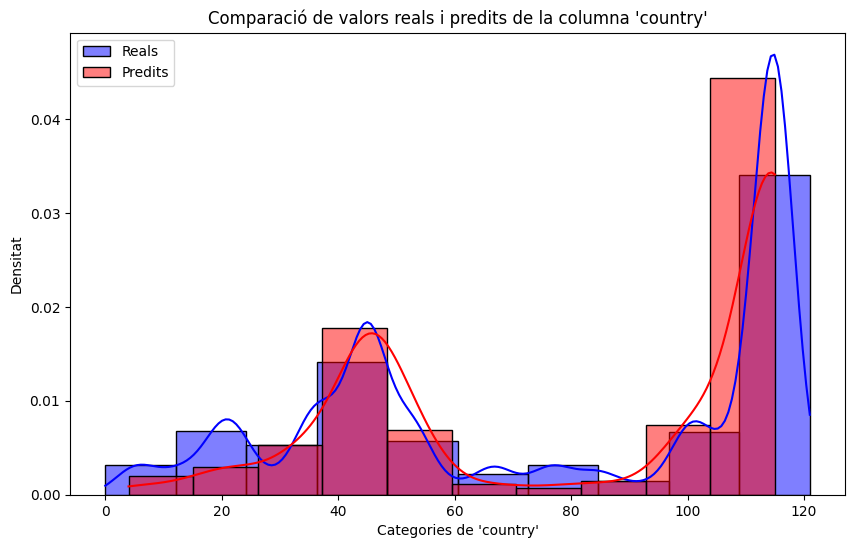

In [38]:
atributs = ['type', 'title', 'director', 'cast', 'release_year', 'rating', 'duration', 'listed_in', 'description']

label_encoders = {}
for column in atributs:  
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])  
    label_encoders[column] = le

known_country = df[df['country'].notnull()]
unknown_country = df[df['country'].isnull()]

le_country = LabelEncoder()
known_country['country'] = le_country.fit_transform(known_country['country'])

X_train = known_country.drop('country', axis=1)
y_train = known_country['country']
X_unknown = unknown_country.drop('country', axis=1)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

predicted_countries = rfc.predict(X_unknown)
predicted_countries = le_country.inverse_transform(predicted_countries)

df.loc[df['country'].isnull(), 'country'] = predicted_countries

plt.figure(figsize=(10, 6))
sns.histplot(known_country['country'], color='blue', label='Reals', kde=True, stat='density', bins=10)
sns.histplot(le_country.transform(predicted_countries), color='red', label='Predits', kde=True, stat='density', bins=10)

plt.legend()
plt.title("Comparació de valors reals i predits de la columna 'country'")
plt.xlabel("Categories de 'country'")
plt.ylabel("Densitat")
plt.show()

for column, le in label_encoders.items():
    df[column] = le.inverse_transform(df[column])


In [9]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director', 'cast']
  
Columnes amb nans i els seus percentatges:

director    25.071921
cast         1.062592
dtype: float64


Per eliminar els valors nuls dels atributs **Cast i Director** en comptes d'utilitzar Random Forest Classifier, utilitzem **KNN Imputer**, ja que hi ha un nombre molt gran d'actors i directors. 

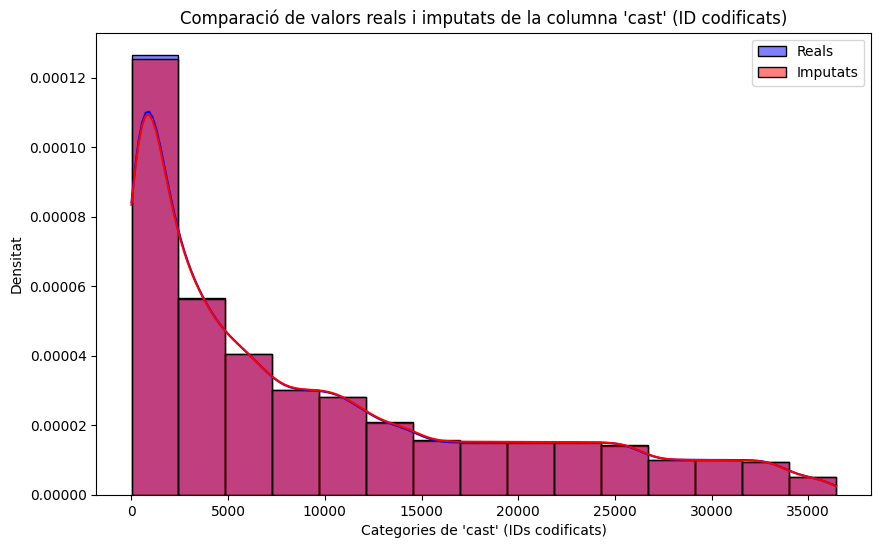

In [ ]:
atribtus = ['type', 'country', 'release_year', 'rating', 'duration', 'listed_in']

label_encoders = {}

for col in atribtus:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    
cast_mapping = {name: idx for idx, name in enumerate(df['cast'].value_counts().index, 1)}
df['cast'] = df['cast'].map(cast_mapping)

knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = knn_imputer.fit_transform(df[atribtus + ['cast']])

df_imputed = pd.DataFrame(df_imputed, columns=atribtus + ['cast'])


real_cast = df[df['cast'].notnull()]['cast']
imputed_cast = df_imputed['cast']

plt.figure(figsize=(10, 6))
sns.histplot(real_cast, color='blue', label='Reals', kde=True, stat='density', bins=15)
sns.histplot(imputed_cast, color='red', label='Imputats', kde=True, stat='density', bins=15)


plt.legend()
plt.title("Comparació de valors reals i imputats de la columna 'cast' (ID codificats)")
plt.xlabel("Categories de 'cast' (IDs codificats)")
plt.ylabel("Densitat")
plt.show()

for col in atribtus + ['cast']:
    df[col] = df_imputed[col]

reverse_cast_mapping = {v: k for k, v in cast_mapping.items()}
df['cast'] = df['cast'].apply(lambda x: np.nan if np.isnan(x) else reverse_cast_mapping.get(int(x), np.nan))

for column, le in label_encoders.items():
    if column in df.columns:
        df[column] = le.inverse_transform(df[column].astype(int))

In [11]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director']
  
Columnes amb nans i els seus percentatges:

director    25.071921
dtype: float64


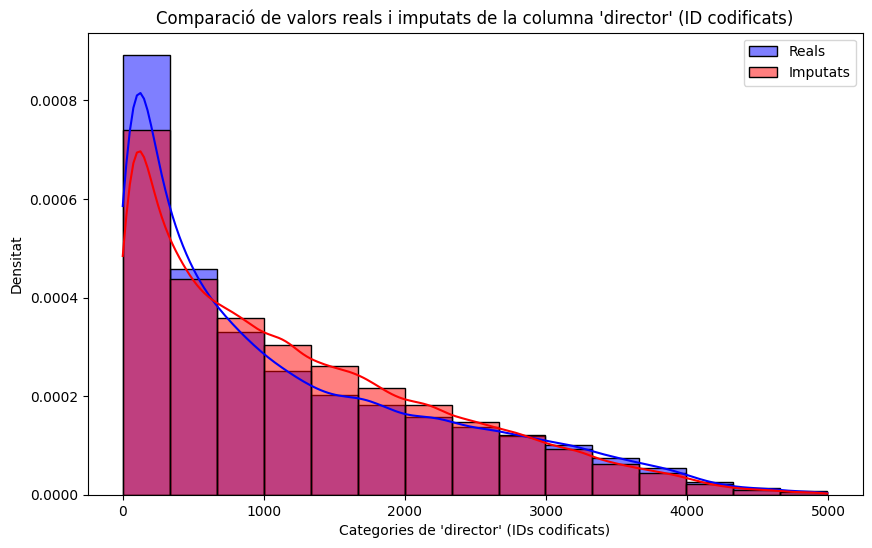

In [ ]:
atribtus = ['type', 'country', 'cast', 'release_year', 'rating', 'duration', 'listed_in']

label_encoders = {}

for col in atribtus:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

director_mapping = {name: idx for idx, name in enumerate(df['director'].value_counts().index, 1)}
df['director'] = df['director'].map(director_mapping)

knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = knn_imputer.fit_transform(df[atribtus + ['director']])

df_imputed = pd.DataFrame(df_imputed, columns=atribtus + ['director'])

real_director = df[df['director'].notnull()]['director']
imputed_director = df_imputed['director']

plt.figure(figsize=(10, 6))
sns.histplot(real_director, color='blue', label='Reals', kde=True, stat='density', bins=15)
sns.histplot(imputed_director, color='red', label='Imputats', kde=True, stat='density', bins=15)

plt.legend()
plt.title("Comparació de valors reals i imputats de la columna 'director' (ID codificats)")
plt.xlabel("Categories de 'director' (IDs codificats)")
plt.ylabel("Densitat")
plt.show()

for col in atribtus + ['director']:
    df[col] = df_imputed[col]

reverse_director_mapping = {v: k for k, v in director_mapping.items()}
df['director'] = df['director'].apply(lambda x: np.nan if np.isnan(x) else reverse_director_mapping.get(int(x), np.nan))

for column, le in label_encoders.items():
    if column in df.columns:
        df[column] = le.inverse_transform(df[column].astype(int))

In [9]:
print(cast_mapping)
print(director_mapping)

{'Liam Neeson': 1, 'Alfred Molina': 2, 'John Krasinski': 3, 'Salma Hayek': 4, 'Frank Langella': 5, 'Anupam Kher': 6, 'John Rhys-Davies': 7, 'Shah Rukh Khan': 8, 'Naseeruddin Shah': 9, 'Radhika Apte': 10, 'David Attenborough': 11, 'James Franco': 12, 'Quvenzhané Wallis': 13, 'Tara Strong': 14, 'James Faulkner': 15, 'Jim Broadbent': 16, 'Akshay Kumar': 17, 'Paresh Rawal': 18, 'Om Puri': 19, 'Paul Giamatti': 20, 'Ben Whishaw': 21, 'Luci Christian': 22, 'Yuki Kaji': 23, 'Amitabh Bachchan': 24, 'Boman Irani': 25, 'Takahiro Sakurai': 26, 'Nawazuddin Siddiqui': 27, 'John Cleese': 28, 'Kareena Kapoor': 29, 'Halle Berry': 30, 'Hugo Weaving': 31, 'John Swasey': 32, 'Andy McAvin': 33, 'Anton Yelchin': 34, 'Keith David': 35, 'Fred Armisen': 36, 'Kay Kay Menon': 37, 'Donnie Yen': 38, 'Jackie Chan': 39, 'Willem Dafoe': 40, 'Jim Sturgess': 41, 'Stellan Skarsgård': 42, 'Gulshan Grover': 43, 'Fred Tatasciore': 44, 'Guy Pearce': 45, 'Amrish Puri': 46, 'Anil Kapoor': 47, 'Daisuke Ono': 48, 'Priyanka Chop

In [13]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist() 

Tenim nans en els atributs:
[]
  
Columnes amb nans i els seus percentatges:

Series([], dtype: float64)


### **3.3 AGRUPACIÓ**

In [64]:
unique_genres = set(genre.strip() for genres in df['listed_in'] for genre in genres.split(','))
print(len(unique_genres))
print(unique_genres)


42
{'TV Thrillers', "Kids' TV", 'International TV Shows', 'Romantic Movies', 'Thrillers', 'Korean TV Shows', 'Reality TV', 'Movies', 'Documentaries', 'Teen TV Shows', 'Romantic TV Shows', 'TV Sci-Fi & Fantasy', 'Sports Movies', 'Action & Adventure', 'Horror Movies', 'Classic & Cult TV', 'TV Action & Adventure', 'Sci-Fi & Fantasy', 'Stand-Up Comedy & Talk Shows', 'International Movies', 'Classic Movies', 'Anime Series', 'TV Comedies', 'Stand-Up Comedy', 'Docuseries', 'TV Horror', 'TV Mysteries', 'TV Dramas', 'Anime Features', 'Children & Family Movies', 'British TV Shows', 'TV Shows', 'Faith & Spirituality', 'Spanish-Language TV Shows', 'Independent Movies', 'Comedies', 'Science & Nature TV', 'Dramas', 'Cult Movies', 'LGBTQ Movies', 'Music & Musicals', 'Crime TV Shows'}


In [41]:
group_mapping = {
    'Horror': ['Thrillers', 'Horror Movies'],
    'TV Horror': ['TV Horror', 'Crime TV Shows', 'TV Mysteries', 'TV Thrillers'],
    'Drama and romance': ['Dramas', 'Romantic Movies', 'Independent Movies', 'Movies'],
    'TV Drama and romance': ['TV Dramas', 'Romantic TV Shows', 'Teen TV Shows'],
    'Comedy': ['Comedies', 'Stand-Up Comedy'],
    'TV Comedy': ['TV Comedies', 'Stand-Up Comedy & Talk Shows'],
    'International': ['International Movies'],
    'TV International': ['International TV Shows', 'British TV Shows', 'Spanish-Language TV Shows', 'Korean TV Shows'],
    'Family': ['Children & Family Movies'],
    'TV Family': ["Kids' TV"],
    'Fantasy': ['Sci-Fi & Fantasy'],
    'TV Fantasy': ['TV Sci-Fi & Fantasy'],
    'Action & Adventure': ['Action & Adventure'],
    'TV Action & Adventure': ['TV Action & Adventure'],
    'Documentaries & education': ['Documentaries', 'Faith & Spirituality'],
    'TV Documentaries & education': ['Docuseries', 'Science & Nature TV'],
    'Anime': ['Anime Features'],
    'TV Anime': ['Anime Series'],
    'Music': ['Music & Musicals'],
    'Sports': ['Sports Movies'],
    'Classic & cult': ['Classic Movies', 'Cult Movies', 'LGBTQ Movies'],
    'TV Classic & Cult': ['Classic & Cult TV'],
    'TV Reality': ['TV Shows', 'Reality TV']
}

def group_categories(row, group_mapping):
    categories = row.split(',') 
    new_categories = []
    
    for category in categories:
        category = category.strip()  
        matched = False
        for group, values in group_mapping.items():
            if category in values:  
                new_categories.append(group)  
                matched = True
                break  
        if not matched:
            new_categories.append(category)  
    
    return ','.join(new_categories)  

df['listed_in'] = df['listed_in'].apply(lambda x: group_categories(x, group_mapping))

### **3.3 NORMALITZACIÓ**

### **3.4 VISUALITZACIÓ DELS ATRIBUTS**

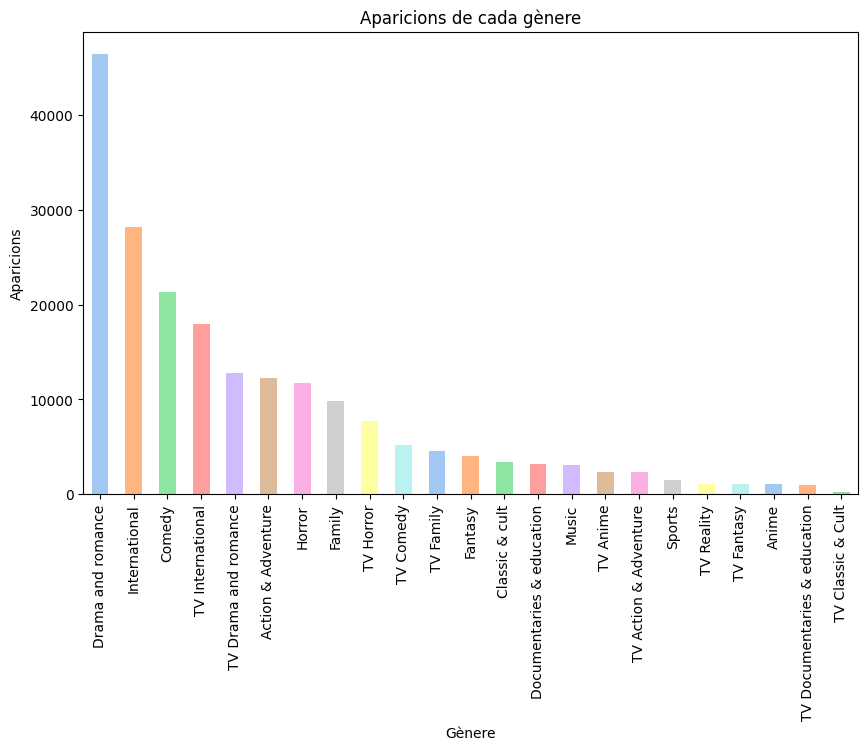

In [66]:
all_genres = [genre.strip() for genres in df['listed_in'] for genre in genres.split(',')]

genre_counts = pd.Series(all_genres).value_counts()
colors = sns.color_palette("pastel", len(genre_counts))

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada gènere")
plt.xlabel("Gènere")
plt.ylabel("Aparicions")
plt.show()


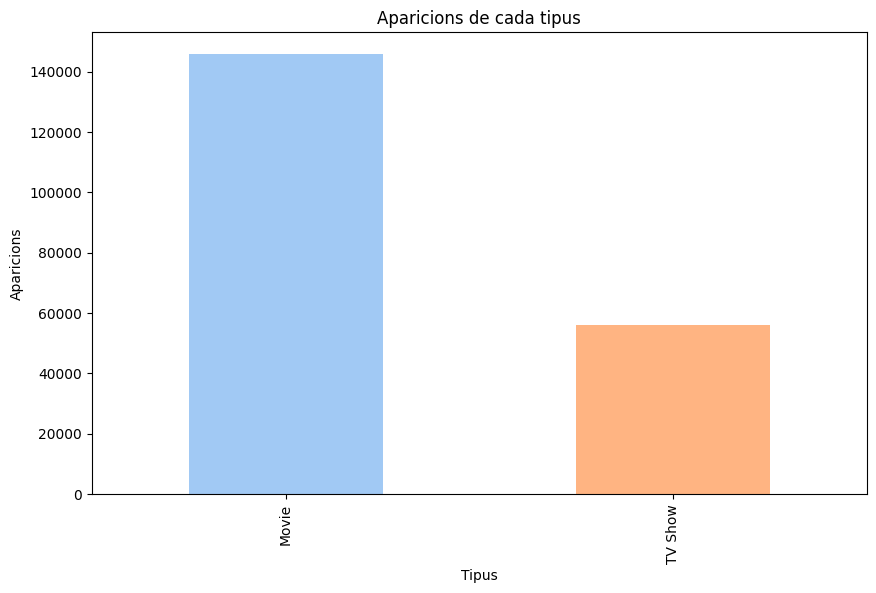

In [67]:
types = [genre.strip() for genres in df['type'] for genre in genres.split(',')]
type_counts = pd.Series(types).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada tipus")
plt.xlabel("Tipus")
plt.ylabel("Aparicions")
plt.show()

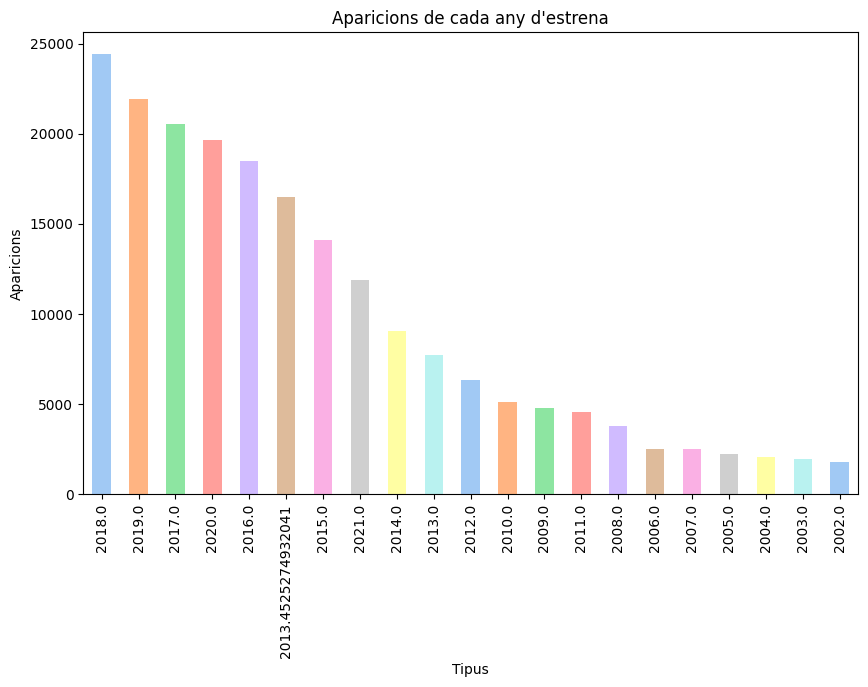

In [68]:
release_years = [genre.strip() for genres in df['release_year'] for genre in genres.split(',')]
type_counts = pd.Series(release_years).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada any d'estrena")
plt.xlabel("Tipus")
plt.ylabel("Aparicions")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


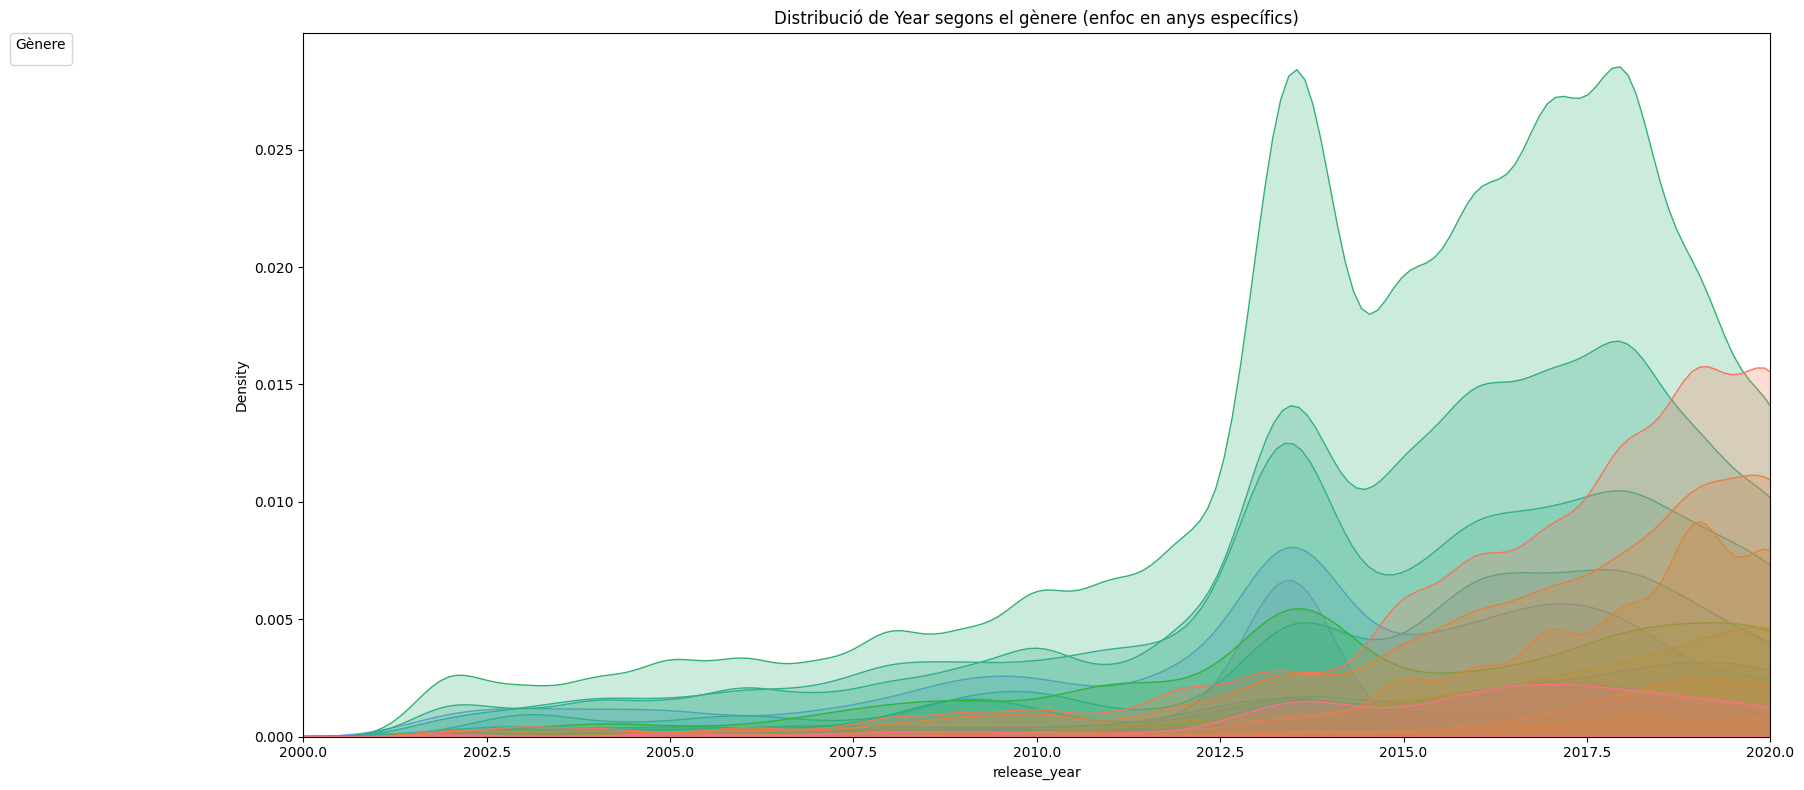

In [ ]:
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

df['listed_in'] = df['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = df.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

fig, axes = plt.subplots(1, 1, figsize=(18, 8))

sns.kdeplot(data=df_copia, x='release_year', hue='listed_in', fill=True, ax=axes)

axes.set_xlim(2000, 2020)  
axes.legend(title="Gènere", bbox_to_anchor=(-0.2, 1), loc='upper left', borderaxespad=0)

plt.title("Distribució de Year segons el gènere (enfoc en anys específics)")
plt.tight_layout()  
plt.show()


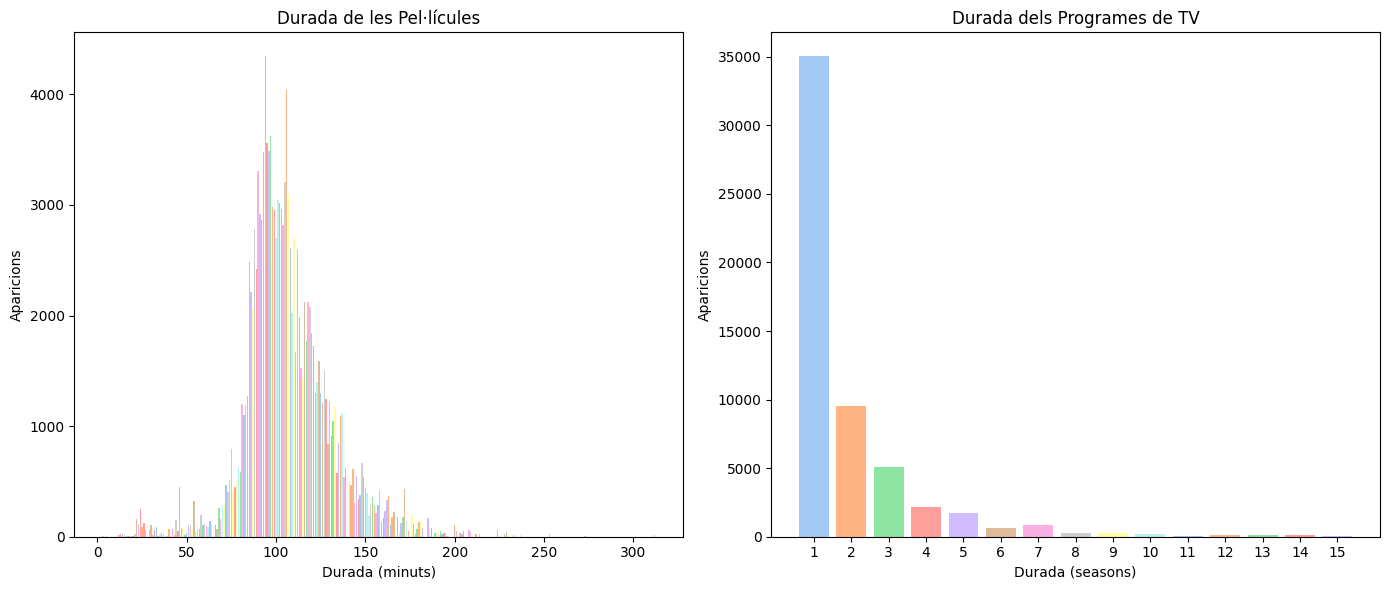

In [70]:
movie_df = df[df['type'] == 'Movie']
tv_show_df = df[df['type'] == 'TV Show']

movie_duration = movie_df['duration'].str.replace(' min', '').astype(int)
tv_show_duration = tv_show_df['duration'].str.replace(r'[^0-9]', '', regex=True).astype(int)

movie_duration_counts = movie_duration.value_counts()
tv_show_duration_counts = tv_show_duration.value_counts()

movie_colors = sns.color_palette("pastel", len(movie_duration_counts))
tv_show_colors = sns.color_palette("pastel", len(tv_show_duration_counts))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(movie_duration_counts.index, movie_duration_counts.values, color=movie_colors)
axes[0].set_title("Durada de les Pel·lícules")
axes[0].set_xlabel("Durada (minuts)")
axes[0].set_ylabel("Aparicions")

tv_show_duration_counts_sorted = tv_show_duration_counts.sort_index()  

axes[1].bar(range(1, len(tv_show_duration_counts_sorted) + 1), tv_show_duration_counts_sorted.values, color=tv_show_colors)
axes[1].set_title("Durada dels Programes de TV")
axes[1].set_xlabel("Durada (seasons)")
axes[1].set_ylabel("Aparicions")
axes[1].set_xticks(range(1, len(tv_show_duration_counts_sorted) + 1))
axes[1].set_xticklabels(range(1, len(tv_show_duration_counts_sorted) + 1))

plt.tight_layout()
plt.show()


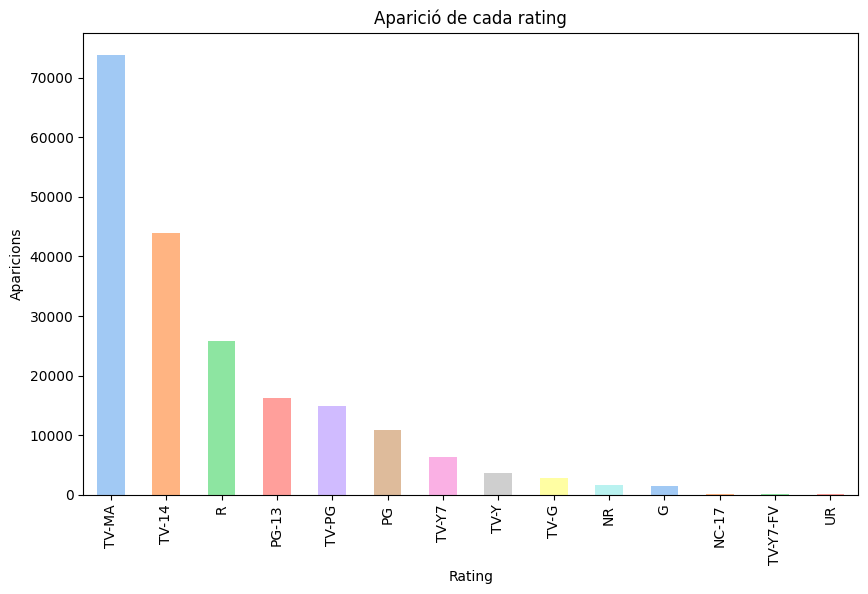

In [71]:
ratings = [genre.strip() for genres in df['rating'] for genre in genres.split(',')]
type_counts = pd.Series(ratings).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparició de cada rating")
plt.xlabel("Rating")
plt.ylabel("Aparicions")
plt.show()

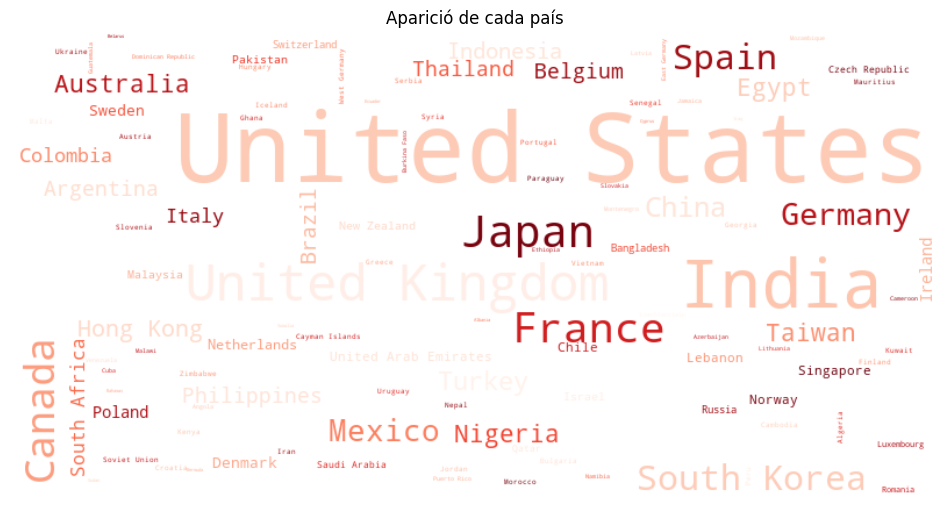

In [72]:
countries = [genre.strip() for genres in df['country'] for genre in genres.split(',')]
type_counts = pd.Series(countries).value_counts()

country_freq = type_counts.to_dict()

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(country_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Aparició de cada país")
plt.show()

Per corroborar que el word cloud està be, mirem quins son els actors més comuns del dataset un cop feta la predicció dels nans.

In [73]:
actors_individuals = df['cast'].str.split(', ').explode()
top_10_individual_actors = actors_individuals.value_counts().head(10)

print(top_10_individual_actors)

cast
Liam Neeson         161
Alfred Molina       160
John Krasinski      139
Salma Hayek         130
Frank Langella      128
Anupam Kher         127
John Rhys-Davies    125
Shah Rukh Khan      108
Naseeruddin Shah    106
Radhika Apte        104
Name: count, dtype: int64


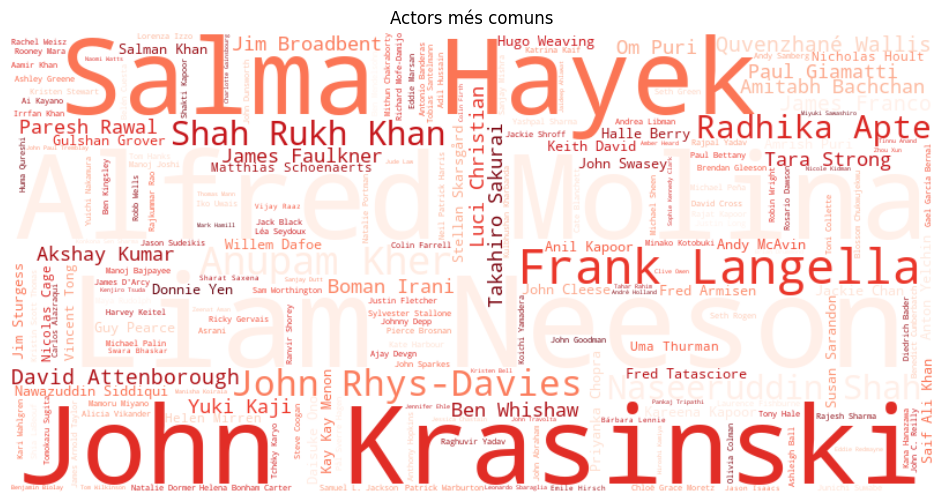

In [74]:
actor_counts = actors_individuals.value_counts()  
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(actor_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Actors més comuns")
plt.show()

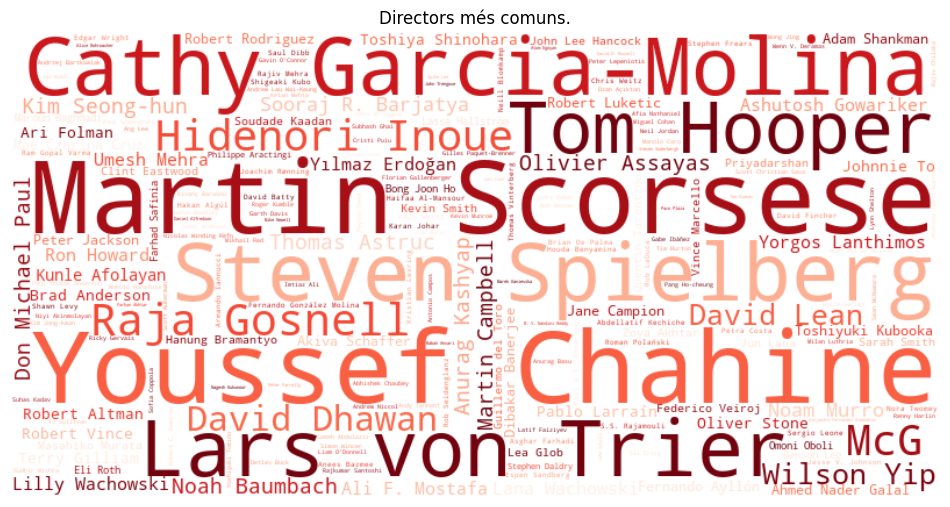

In [75]:
directors = [genre.strip() for genres in df['director'] for genre in genres.split(',')]
type_counts = pd.Series(directors).value_counts()

directors_freq = type_counts.to_dict()

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(directors_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Directors més comuns.")
plt.show()


### **3.4 CORRELACIÓ ENTRE ELS ATRIBUTS**

<Figure size 1500x800 with 0 Axes>

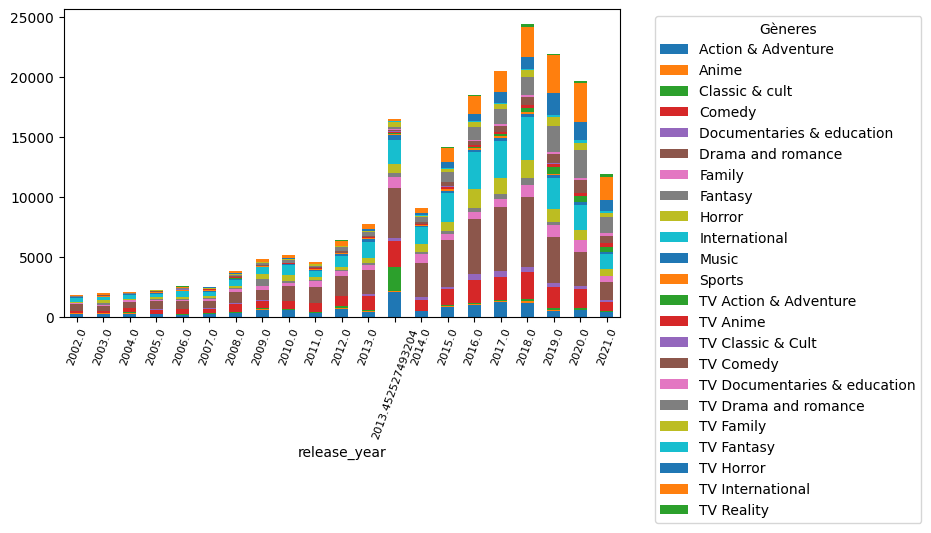

In [76]:
top_years = df['release_year'].value_counts().nlargest(54).index
d_f = df[df['release_year'].isin(top_years)]

d_f['release_year'] = d_f['release_year'].where(d_f['release_year'].isin(top_years), 'Other')

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['release_year', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout() 

plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


<Figure size 1500x800 with 0 Axes>

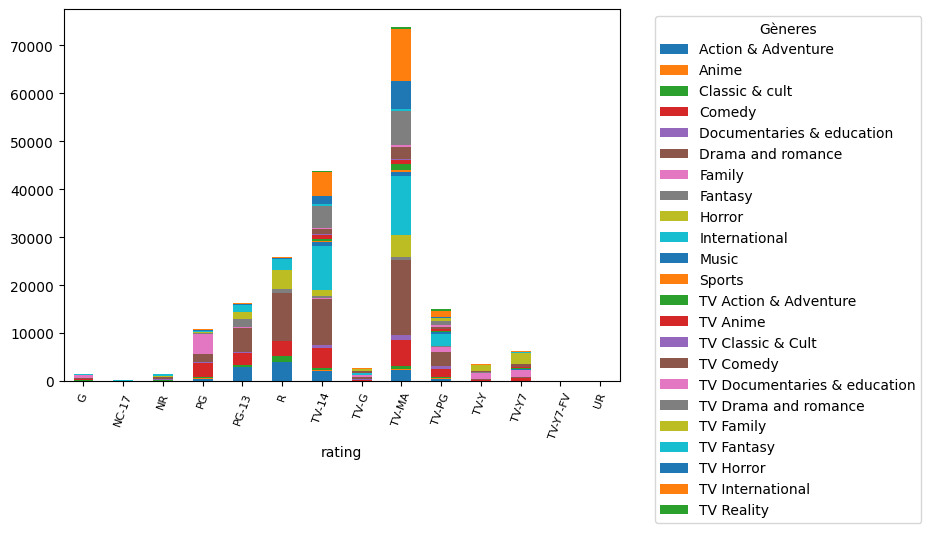

In [77]:
top_ratings = df['rating'].value_counts().nlargest(54).index
d_f = df[df['rating'].isin(top_ratings)]

d_f['rating'] = d_f['rating'].where(d_f['rating'].isin(top_ratings), 'Other')

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['rating', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout()  

plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_10428\814609895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['country'] = d_f['country'].where(d_f['country'].isin(top_countries), 'Other')
C:\Users\USER\AppData\Local\Temp\ipykernel_10428\814609895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))


<Figure size 1500x800 with 0 Axes>

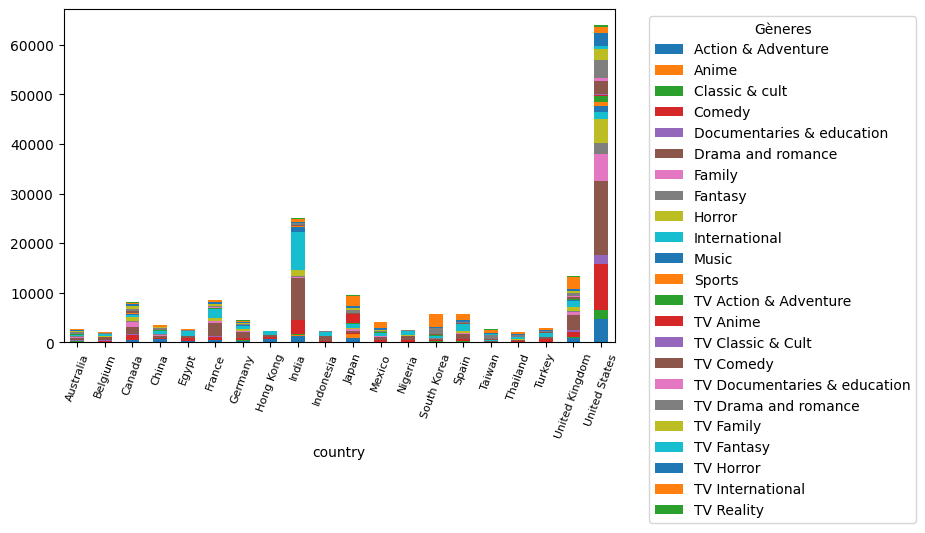

In [78]:
top_countries = df['country'].value_counts().nlargest(20).index
d_f = df[df['country'].isin(top_countries)]

d_f['country'] = d_f['country'].where(d_f['country'].isin(top_countries), 'Other')
d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(country=df_copia['country'].str.split(', '))
df_copia = df_copia.explode('country')  

df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['country', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_10428\1202718448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['cast'] = d_f['cast'].apply(lambda x: ', '.join([c for c in x.split(', ') if c in top_casts]))
C:\Users\USER\AppData\Local\Temp\ipykernel_10428\1202718448.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))


<Figure size 1500x800 with 0 Axes>

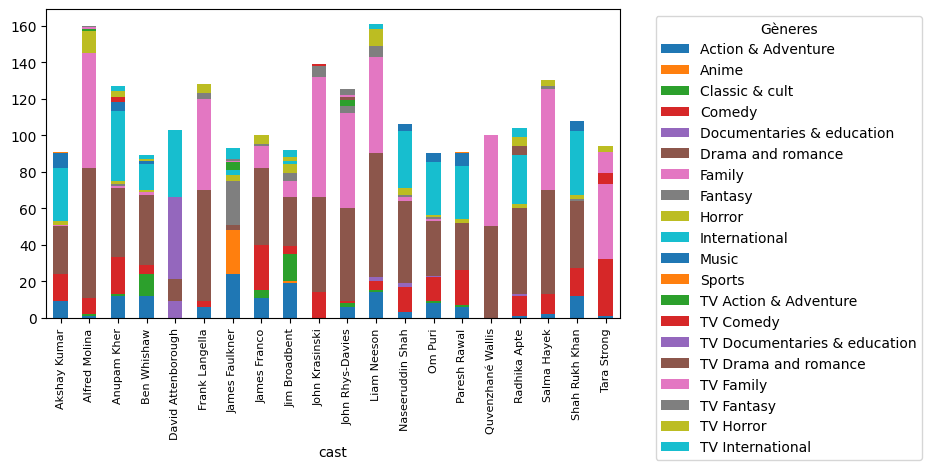

In [79]:
top_casts = df['cast'].dropna().str.split(', ').explode().value_counts().nlargest(20).index

d_f= df[df['cast'].notna() & df['cast'].str.split(', ').apply(lambda x: any(c in top_casts for c in x))]

d_f['cast'] = d_f['cast'].apply(lambda x: ', '.join([c for c in x.split(', ') if c in top_casts]))

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(cast=df_copia['cast'].str.split(', '))
df_copia = df_copia.explode('cast')  

df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['cast', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=90, fontsize=8)  
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_10428\1084726458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['director'] = d_f['director'].apply(lambda x: ', '.join([d for d in x.split(', ') if d in top_directors]))
C:\Users\USER\AppData\Local\Temp\ipykernel_10428\1084726458.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))


<Figure size 1500x800 with 0 Axes>

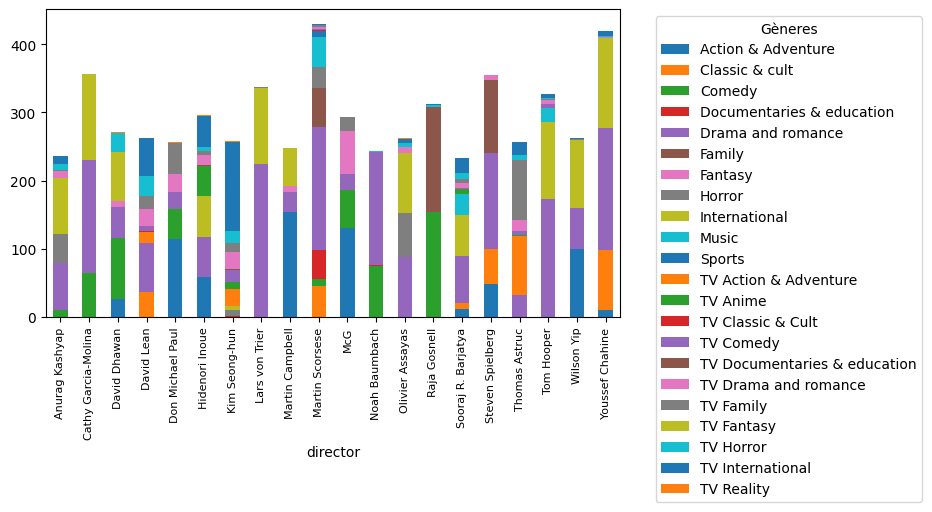

In [80]:
top_directors = df['director'].dropna().str.split(', ').explode().value_counts().nlargest(20).index

d_f = df[df['director'].notna() & df['director'].str.split(', ').apply(lambda x: any(d in top_directors for d in x))]

d_f['director'] = d_f['director'].apply(lambda x: ', '.join([d for d in x.split(', ') if d in top_directors]))

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(director=df_copia['director'].str.split(', '))
df_copia = df_copia.explode('director')

df_copia = df_copia[df_copia['director'].isin(top_directors)]

df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')


data = df_copia.groupby(['director', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8)) 
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=90, fontsize=8)  
plt.tight_layout()  


plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


<Figure size 1500x800 with 0 Axes>

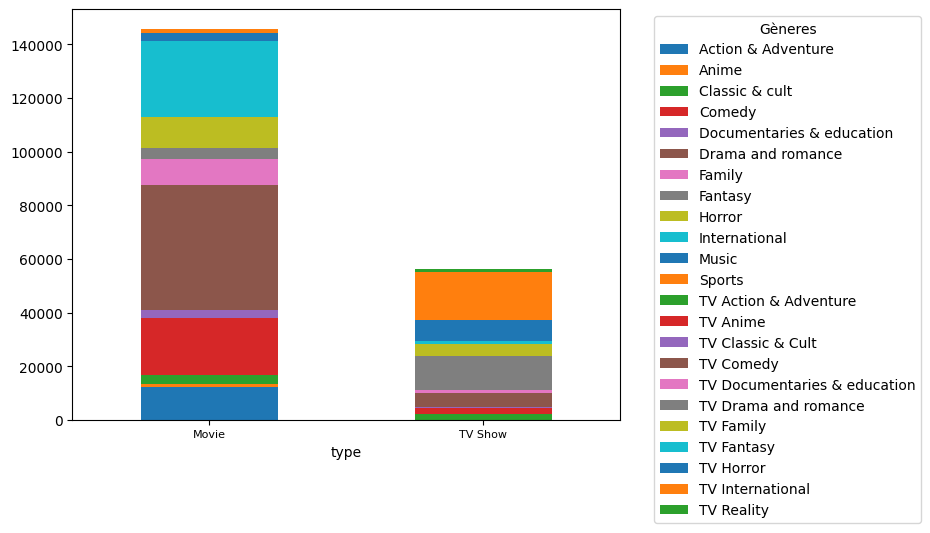

In [81]:
types = df['type'].value_counts().nlargest(54).index
d_f = df[df['type'].isin(types)]

d_f['type'] = d_f['type'].where(d_f['type'].isin(types), 'Other')

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['type', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8)) 
data.plot(kind='bar', stacked=True, legend=False) 
plt.xticks(rotation=0, fontsize=8)  
plt.tight_layout()  

plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


### **3.2 ENCODING**

Les variables categòriques que volem convertir a numèriques són les següents:**Type**, **Rating**, **title,director,cast,country, listed_in,description**. 
Observem quants valors únics tenim per saber com tractar-les. 

Una vegada observats el nombre de valors únics de cada atributs prenem les desicions següents.

* Apliquem **LabelEncoder** per **type**
* Apliquem **OneHotEncoder** per **rating i listed_in**
* Apliquem **Random Category Encoding** per **director, cast i country**
* Apliquem **Bag of Words** per **description i title**
* Categorical naive bayesian

In [42]:

columns_of_interest = ['type', 'rating', 'title', 'director', 'cast', 'country', 'listed_in', 'description']
unique_values = df[columns_of_interest].nunique()
print(unique_values)


type               2
rating            14
title           8807
director        4993
cast           36439
country          122
listed_in         23
description     8775
dtype: int64


In [43]:
label_encoder_type = LabelEncoder()
df['type'] = label_encoder_type.fit_transform(df['type'])
print("Type codificat:\n", df['type'])


Type codificat:
 0         0
1         1
2         1
3         1
4         1
         ..
201954    0
201955    0
201956    0
201957    0
201958    0
Name: type, Length: 201959, dtype: int32


In [44]:
columns_to_encode = ['rating', 'listed_in']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[columns_to_encode])
encoded_columns = encoder.get_feature_names_out(columns_to_encode)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)

df = pd.concat([df, encoded_df], axis=1)
print(df.head())

   type                 title         director            cast        country  \
0     0  Dick Johnson Is Dead  Kirsten Johnson  Cody Merridith  United States   
1     1         Blood & Water    Leung Lok Man      Ama Qamata   South Africa   
2     1         Blood & Water    Leung Lok Man      Ama Qamata   South Africa   
3     1         Blood & Water    Leung Lok Man      Ama Qamata   South Africa   
4     1         Blood & Water     Suseenthiran     Khosi Ngema   South Africa   

  release_year rating   duration                  listed_in  \
0         2020  PG-13     90 min  Documentaries & education   
1         2021  TV-MA  2 Seasons           TV International   
2         2021  TV-MA  2 Seasons       TV Drama and romance   
3         2021  TV-MA  2 Seasons                  TV Horror   
4         2021  TV-MA  2 Seasons           TV International   

                                         description  ...  listed_in_TV Anime  \
0  As her father nears the end of his life, filmm... 

In [15]:
print(df.columns)

Index(['type', 'title', 'director', 'cast', 'country', 'release_year',
       'rating', 'duration', 'listed_in', 'description', 'rating_G',
       'rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R',
       'rating_TV-14', 'rating_TV-G', 'rating_TV-MA', 'rating_TV-PG',
       'rating_TV-Y', 'rating_TV-Y7', 'rating_TV-Y7-FV', 'rating_UR',
       'listed_in_Action & Adventure', 'listed_in_Anime',
       'listed_in_Classic & cult', 'listed_in_Comedy',
       'listed_in_Documentaries & education', 'listed_in_Drama and romance',
       'listed_in_Family', 'listed_in_Fantasy', 'listed_in_Horror',
       'listed_in_International', 'listed_in_Music', 'listed_in_Sports',
       'listed_in_TV Action & Adventure', 'listed_in_TV Anime',
       'listed_in_TV Classic & Cult', 'listed_in_TV Comedy',
       'listed_in_TV Documentaries & education',
       'listed_in_TV Drama and romance', 'listed_in_TV Family',
       'listed_in_TV Fantasy', 'listed_in_TV Horror',
       'listed_in_TV

In [ ]:

print(df[['cast']].head())
print(df[['director']].head())
print(df[['country']].head())

def map_categorical_to_numeric(df, column):
    
    unique_values = df[column].unique()

    random_mapping = {val: np.random.randint(1000, 9999) for val in unique_values}
    
    df[column] = df[column].map(random_mapping)
    
    return df


df = map_categorical_to_numeric(df, 'cast')
df = map_categorical_to_numeric(df, 'director')
df = map_categorical_to_numeric(df, 'country')


print(df[['cast']].head())
print(df[['director']].head())
print(df[['country']].head())


             cast
0  Cody Merridith
1      Ama Qamata
2      Ama Qamata
3      Ama Qamata
4     Khosi Ngema
          director
0  Kirsten Johnson
1    Leung Lok Man
2    Leung Lok Man
3    Leung Lok Man
4     Suseenthiran
         country
0  United States
1   South Africa
2   South Africa
3   South Africa
4   South Africa
   cast
0  1511
1  3141
2  3141
3  3141
4  1201
   director
0      4567
1      6178
2      6178
3      6178
4      2553
   country
0     9337
1     9494
2     9494
3     9494
4     9494


In [ ]:

nltk.download('stopwords')

print("Abans de la transformació:")
print(df['title'].head())
print(df['description'].head())

english_stop_words = text.ENGLISH_STOP_WORDS
spanish_stop_words = stopwords.words('spanish')

combined_stop_words = list(set(english_stop_words).union(set(spanish_stop_words)))

custom_token_pattern = r'(?u)\b[A-Za-z][A-Za-z0-9]+\b'

vectorizer_title = CountVectorizer(stop_words=combined_stop_words, token_pattern=custom_token_pattern, max_features=20)

vectorizer_description = CountVectorizer(stop_words=combined_stop_words, token_pattern=custom_token_pattern, max_features=20)

word_counts_title = vectorizer_title.fit_transform(df['title'])
word_counts_description = vectorizer_description.fit_transform(df['description'])

word_counts_df_title = pd.DataFrame(word_counts_title.toarray(), columns=vectorizer_title.get_feature_names_out())
word_counts_df_description = pd.DataFrame(word_counts_description.toarray(), columns=vectorizer_description.get_feature_names_out())

word_freq = word_counts_df_title.sum().sort_values(ascending=False)
word_freq_1 = word_counts_df_description.sum().sort_values(ascending=False)

df = pd.concat([df, word_counts_df_title], axis=1)
df = pd.concat([df, word_counts_df_description], axis=1)

print("Després de la transformació:")
print(df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Abans de la transformació:
0    Dick Johnson Is Dead
1           Blood & Water
2           Blood & Water
3           Blood & Water
4           Blood & Water
Name: title, dtype: object
0    As her father nears the end of his life, filmm...
1    After crossing paths at a party, a Cape Town t...
2    After crossing paths at a party, a Cape Town t...
3    After crossing paths at a party, a Cape Town t...
4    After crossing paths at a party, a Cape Town t...
Name: description, dtype: object
Després de la transformació:
   type                 title  director  cast  country release_year rating  \
0     0  Dick Johnson Is Dead      4567  1511     9337         2020  PG-13   
1     1         Blood & Water      6178  3141     9494         2021  TV-MA   
2     1         Blood & Water      6178  3141     9494         2021  TV-MA   
3     1         Blood & Water      6178  3141     9494         2021  TV-MA   
4     1         Blood & Water      2553  1201     9494         2021  TV-MA   

    durati

In [19]:
print('20 més freqüents de title')
print(word_freq.head(20))

20 més freqüents de title
love         3870
movie        2604
man          2021
life         1743
christmas    1650
world        1598
black        1581
girl         1436
day          1384
king         1361
story        1247
time         1223
high         1206
little       1203
boy          1123
house        1116
girls        1028
city         1010
american      926
good          879
dtype: int64


In [20]:
print('20 més freqüents de description')
print(word_freq_1.head(20))

20 més freqüents de description
young      20022
life       17905
new        16505
family     15789
man        13004
woman      12897
love       12793
world      12361
friends     8912
school      8602
finds       8031
home        7966
series      7704
high        7588
father      7509
old         7492
girl        7415
teen        6701
help        6542
group       6488
dtype: int64


In [45]:
print(df.columns)

Index(['type', 'title', 'director', 'cast', 'country', 'release_year',
       'rating', 'duration', 'listed_in', 'description', 'rating_G',
       'rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R',
       'rating_TV-14', 'rating_TV-G', 'rating_TV-MA', 'rating_TV-PG',
       'rating_TV-Y', 'rating_TV-Y7', 'rating_TV-Y7-FV', 'rating_UR',
       'listed_in_Action & Adventure', 'listed_in_Anime',
       'listed_in_Classic & cult', 'listed_in_Comedy',
       'listed_in_Documentaries & education', 'listed_in_Drama and romance',
       'listed_in_Family', 'listed_in_Fantasy', 'listed_in_Horror',
       'listed_in_International', 'listed_in_Music', 'listed_in_Sports',
       'listed_in_TV Action & Adventure', 'listed_in_TV Anime',
       'listed_in_TV Classic & Cult', 'listed_in_TV Comedy',
       'listed_in_TV Documentaries & education',
       'listed_in_TV Drama and romance', 'listed_in_TV Family',
       'listed_in_TV Fantasy', 'listed_in_TV Horror',
       'listed_in_TV

Un cop hem obtingut les paraules més freqüents de *title* i *description*, volem comprovar si hi ha relació entre aquestes paraules i el *listed_in* per tal de saber si ens podem beneficiar d'aquesta correlació a l'hora de la classificació.

C:\Users\USER\AppData\Local\Temp\ipykernel_5836\1844394282.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_words_df['listed_in'] = df['listed_in']


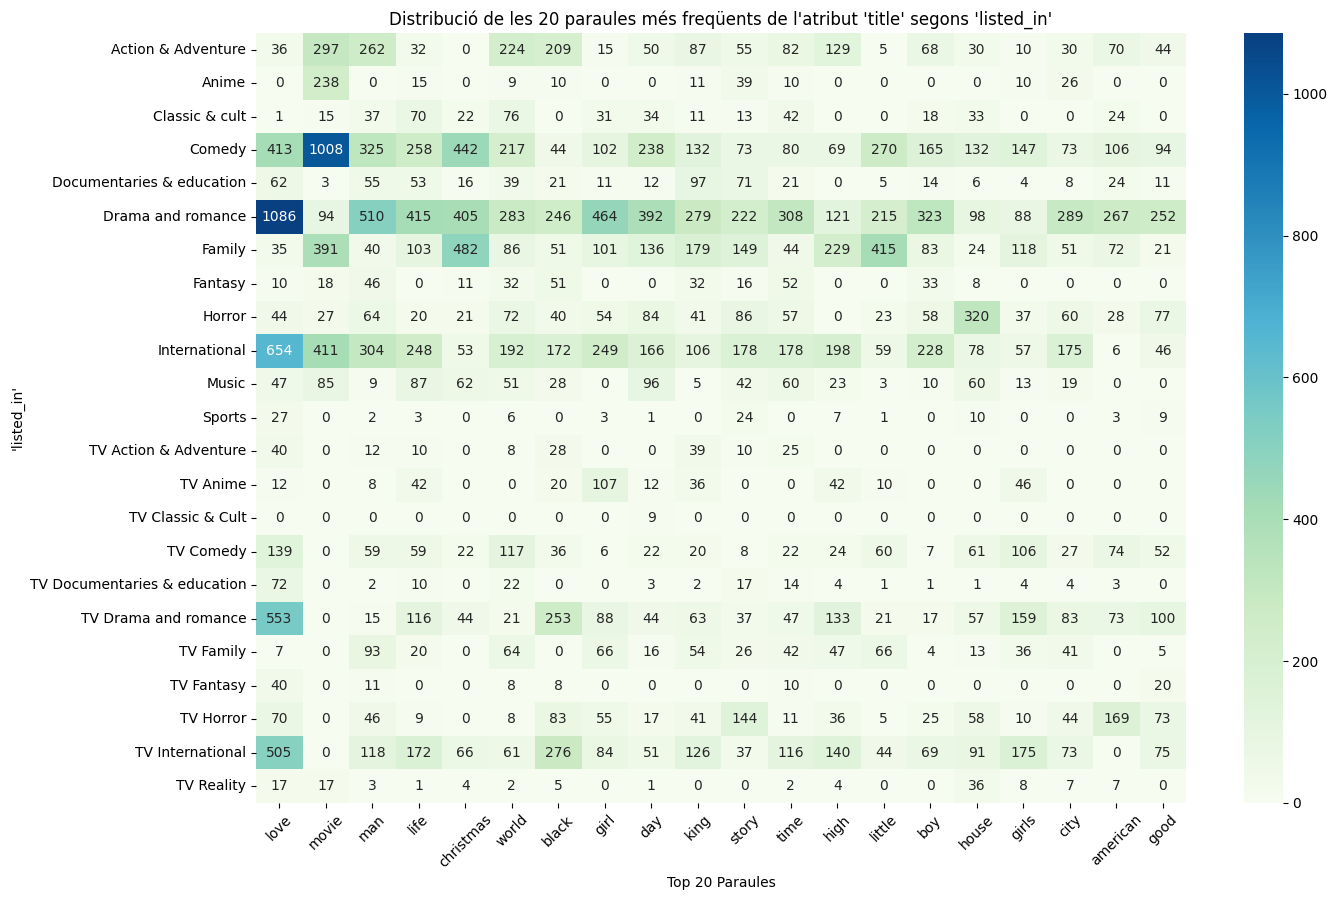

In [16]:
top_20_title = word_freq.head(20).index
top_words_df = word_counts_df_title[top_20_title]
top_words_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

top_words_df['listed_in'] = df['listed_in']

top_words_freq = top_words_df.groupby('listed_in').sum()


plt.figure(figsize=(15, 10))
sns.heatmap(top_words_freq, annot=True, fmt="g", cmap="GnBu")
plt.title("Distribució de les 20 paraules més freqüents de l'atribut 'title' segons 'listed_in'")
plt.xlabel("Top 20 Paraules")
plt.ylabel("'listed_in'")
plt.xticks(rotation=45)
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_11864\4016277761.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_words_description_df['listed_in'] = df['listed_in']


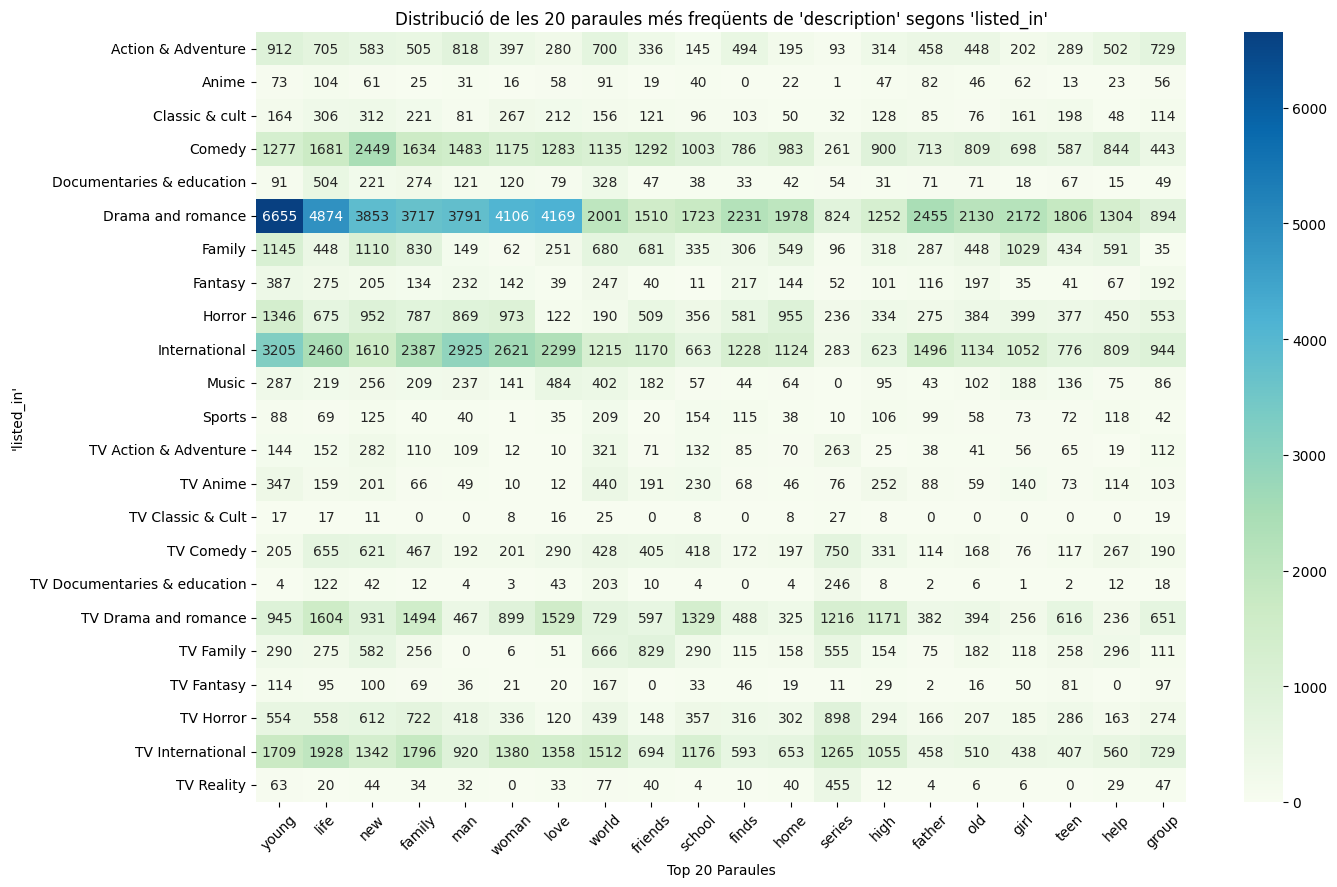

In [23]:

top_20_description = word_freq_1.head(20).index
top_words_description_df = word_counts_df_description[top_20_description]
top_words_description_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

top_words_description_df['listed_in'] = df['listed_in']
top_words_freq_description = top_words_description_df.groupby('listed_in').sum()

plt.figure(figsize=(15, 10))
sns.heatmap(top_words_freq_description, annot=True, fmt="g", cmap="GnBu")
plt.title("Distribució de les 20 paraules més freqüents de 'description' segons 'listed_in'")
plt.xlabel("Top 20 Paraules")
plt.ylabel("'listed_in'")
plt.xticks(rotation=45)
plt.show()


Observem doncs que hi ha patrons evidents entre les paraules i l'atribut *listed_in*. 

Un cop passats tots els atributs a valors numèrics. Visualitzem la matriu de correlació per observar les relacions entre els atributs. 


In [47]:
df['duration'] = df['duration'].str.replace(r'[^0-9]', '', regex=True).astype(int)

### **CLASSIFICACIÓ**

Abans de la classificació, hem d'aplicar un balanceig del nostre target, ja que està molt desbalancejat i per tant, aquest desequilibri pot provocar que el model es concentri més en predir correctament els gèneres majoritaris i ignori els minoritaris.

# **4. METRIC SELECTION**

Com que hem equilibrat el nostre conjunt de dades utilitzant oversampling, hem de tenir cura amb mètriques que poden ser excessivament optimistes en dades sintètiques, com ara l'**accuracy**.

L'**F1 score** és una bona opció. Les curves de **precision-recall** també són molt útils quan es treballa amb conjunts de dades desbalancejats, ja que se centren en el rendiment de la classe positiva.

### **CLASSIFICADOR + RECOMANADOR** (sense feature selection)

In [ ]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB


listed_ins = ['listed_in_Action & Adventure', 'listed_in_Anime',
       'listed_in_Classic & cult', 'listed_in_Comedy',
       'listed_in_Documentaries & education', 'listed_in_Drama and romance',
       'listed_in_Family', 'listed_in_Fantasy', 'listed_in_Horror',
       'listed_in_International', 'listed_in_Music', 'listed_in_Sports',
       'listed_in_TV Action & Adventure', 'listed_in_TV Anime',
       'listed_in_TV Classic & Cult', 'listed_in_TV Comedy',
       'listed_in_TV Documentaries & education',
       'listed_in_TV Drama and romance', 'listed_in_TV Family',
       'listed_in_TV Fantasy', 'listed_in_TV Horror',
       'listed_in_TV International', 'listed_in_TV Reality']

X = df.drop(columns=listed_ins + ['listed_in', 'rating', 'title', 'description'])

predictions = {}

train_f1_scores = []
test_f1_scores = []
train_balanced_accuracies = []
test_balanced_accuracies = []

for genre in listed_ins:
    y = df[genre]  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    class_counts = y_train.value_counts()
    weights = {cls: max(class_counts) / count for cls, count in class_counts.items()}

    model = CategoricalNB()
    model.fit(X_train, y_train)

    proba_train = model.predict_proba(X_train)
    proba_test = model.predict_proba(X_test)

    for cls, weight in weights.items():
        
        cls_index = list(weights.keys()).index(cls)
        proba_train[:, cls_index] *= weight
        proba_test[:, cls_index] *= weight

    predictions_train = np.argmax(proba_train, axis=1)
    predictions_test = np.argmax(proba_test, axis=1)

    predictions[genre] = np.argmax(model.predict_proba(X), axis=1)

    train_f1 = f1_score(y_train, predictions_train, average='macro')
    train_balanced_accuracy = balanced_accuracy_score(y_train, predictions_train)
    train_f1_scores.append(train_f1)
    train_balanced_accuracies.append(train_balanced_accuracy)

    test_f1 = f1_score(y_test, predictions_test, average='macro')
    test_balanced_accuracy = balanced_accuracy_score(y_test, predictions_test)
    test_f1_scores.append(test_f1)
    test_balanced_accuracies.append(test_balanced_accuracy)

    print(f"\n{genre}:")
    print(f"  F1 Score (train): {train_f1:.2f}, F1 Score (test): {test_f1:.2f}")
    print(f"  Balanced Accuracy (train): {train_balanced_accuracy:.2f}, Balanced Accuracy (test): {test_balanced_accuracy:.2f}")

    
    precision, recall, _ = precision_recall_curve(y_test, proba_test[:, 1], pos_label=1)
    pr_auc = auc(recall, precision)
    print(f"  Precision-Recall AUC: {pr_auc:.2f}")


predictions_df = pd.DataFrame(predictions, index=df.index)

def combine_genres(row):
    genres = [genre.replace('listed_in_', '') for genre, value in row.items() if value == 1]
    return ', '.join(genres)

df['classified_genres'] = predictions_df.apply(combine_genres, axis=1)


print(df[['classified_genres']].head())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(listed_ins, train_f1_scores, label='Train F1 Score', marker='o')
plt.plot(listed_ins, test_f1_scores, label='Test F1 Score', marker='o')
plt.title("F1 Score per Genre")
plt.xlabel("Genres")
plt.ylabel("F1 Score")
plt.legend()
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.plot(listed_ins, train_balanced_accuracies, label='Train Balanced Accuracy', marker='o')
plt.plot(listed_ins, test_balanced_accuracies, label='Test Balanced Accuracy', marker='o')
plt.title("Balanced Accuracy per Genre")
plt.xlabel("Genres")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


listed_in_Action & Adventure:
  F1 Score (train): 0.70, F1 Score (test): 0.68
  Balanced Accuracy (train): 0.87, Balanced Accuracy (test): 0.84
  Precision-Recall AUC: 0.39

listed_in_Anime:
  F1 Score (train): 0.75, F1 Score (test): 0.72
  Balanced Accuracy (train): 0.95, Balanced Accuracy (test): 0.92
  Precision-Recall AUC: 0.31

listed_in_Classic & cult:
  F1 Score (train): 0.70, F1 Score (test): 0.68
  Balanced Accuracy (train): 0.90, Balanced Accuracy (test): 0.86
  Precision-Recall AUC: 0.31

listed_in_Comedy:
  F1 Score (train): 0.70, F1 Score (test): 0.67
  Balanced Accuracy (train): 0.84, Balanced Accuracy (test): 0.79
  Precision-Recall AUC: 0.41

listed_in_Documentaries & education:
  F1 Score (train): 0.77, F1 Score (test): 0.73
  Balanced Accuracy (train): 0.90, Balanced Accuracy (test): 0.85
  Precision-Recall AUC: 0.40

listed_in_Drama and romance:
  F1 Score (train): 0.72, F1 Score (test): 0.70
  Balanced Accuracy (train): 0.81, Balanced Accuracy (test): 0.78
  Precis

KeyboardInterrupt: 

In [ ]:
for genre in listed_ins:
    print(f"\nClassificacions per al gènere: {genre}")

    # Obtenir el millor model per al gènere
    best_model = best_models.get(genre)  # `best_models` és un diccionari amb els millors models
    if not best_model:
        print(f"No s'ha trobat un model per al gènere {genre}.")
        continue

    # Seleccionar característiques específiques
    selected_columns = list(selected_features.get(genre, X_test.columns))

    # Verificar si totes les columnes seleccionades existeixen a X_test
    missing_cols = [col for col in selected_columns if col not in X_test.columns]
    for col in missing_cols:
        X_test[col] = 0  # Afegir les columnes mancants amb valors per defecte

    # Filtrar les característiques seleccionades en el test
    X_test_selected = X_test[selected_columns]

    # Realitzar prediccions
    y_pred_test = best_model.predict(X_test_selected)

    # Crear un DataFrame amb les classificacions
    results_df = pd.DataFrame({
        'Real': y_test,
        'Predicció': y_pred_test,
        'Classificació Correcta': y_test == y_pred_test
    })

    # Mostrar una mostra de les classificacions (primeres 10 files)
    print("\nPrimers resultats de classificació:")
    print(results_df.head(50))

    # Comptar quants són correctes i incorrectes
    total_correctes = results_df['Classificació Correcta'].sum()
    total_incorrectes = len(results_df) - total_correctes
    percentatge_encert = 100 * total_correctes / len(results_df)

    # Mostrar un resum de les classificacions
    print(f"\nResum per al gènere {genre}:")
    print(f"  - Total: {len(results_df)}")
    print(f"  - Correctes: {total_correctes}")
    print(f"  - Incorrectes: {total_incorrectes}")
    print(f"  - Percentatge d'encert: {percentatge_encert:.2f}%")

    # Mostrar exemples d'errors
    errors_df = results_df[~results_df['Classificació Correcta']]
    if not errors_df.empty:
        print("\nExemples de classificacions incorrectes:")
        print(errors_df.head(5))
    else:
        print("\nTotes les classificacions han estat correctes per aquest gènere.")


### **FEATURE SELECTION**

* OneHotEncoded: SelectKBest amb chi-squared o Random Forest. 
* LabelEncoded: SelectKBest amb Mutual Information o models basats en arbres com Random Forest, que poden manejar bé la naturalesa d'aquestes variables.

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import CategoricalNB
import numpy as np
from sklearn.model_selection import train_test_split


listed_ins = ['listed_in_Action & Adventure', 'listed_in_Anime', 'listed_in_Classic & cult', 
              'listed_in_Comedy', 'listed_in_Documentaries & education', 'listed_in_Drama and romance',
              'listed_in_Family', 'listed_in_Fantasy', 'listed_in_Horror', 'listed_in_International', 
              'listed_in_Music', 'listed_in_Sports', 'listed_in_TV Action & Adventure', 
              'listed_in_TV Anime', 'listed_in_TV Classic & Cult', 'listed_in_TV Comedy',
              'listed_in_TV Documentaries & education', 'listed_in_TV Drama and romance', 
              'listed_in_TV Family', 'listed_in_TV Fantasy', 'listed_in_TV Horror', 
              'listed_in_TV International', 'listed_in_TV Reality']


X = df.drop(columns=listed_ins + ['listed_in', 'rating', 'title', 'description'])  
y = df[listed_ins] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

selected_features = {}
dropped_features = {}

for genre in listed_ins:
    y_single = y_train[genre]  
    selector_mutual_info = SelectKBest(mutual_info_classif, k="all")
    selector_mutual_info.fit(X_train, y_single)
    
    selector_chi2 = SelectKBest(chi2, k="all")
    selector_chi2.fit(X_train, y_single)
    
    feature_scores_mutual_info = selector_mutual_info.scores_
    feature_scores_chi2 = selector_chi2.scores_
    
    threshold_mutual_info = np.percentile(feature_scores_mutual_info, 50)  
    threshold_chi2 = np.percentile(feature_scores_chi2, 50)  
    selected_mutual_info_features = X.columns[feature_scores_mutual_info >= threshold_mutual_info]
    selected_chi2_features = X.columns[feature_scores_chi2 >= threshold_chi2]
    
    
    all_selected_features = set(selected_mutual_info_features).union(set(selected_chi2_features))
    
    all_dropped_features = set(X.columns) - all_selected_features
    
    
    selected_features[genre] = all_selected_features
    dropped_features[genre] = all_dropped_features


for genre in listed_ins:
    print(f"\n{genre} - Característiques seleccionades:")
    print(selected_features[genre])
    print(f"Característiques descartades:")
    print(dropped_features[genre])



listed_in_Action & Adventure - Característiques seleccionades:
{'rating_R', 'cast', 'man', 'family', 'country', 'young', 'rating_TV-G', 'love', 'woman', 'home', 'rating_G', 'duration', 'black', 'life', 'rating_TV-MA', 'series', 'rating_TV-Y', 'world', 'release_year', 'rating_TV-14', 'new', 'school', 'movie', 'type', 'group', 'director', 'rating_TV-PG', 'christmas', 'girl', 'rating_TV-Y7', 'rating_PG-13'}
Característiques descartades:
{'girls', 'help', 'little', 'finds', 'time', 'house', 'high', 'father', 'rating_NR', 'story', 'american', 'king', 'rating_TV-Y7-FV', 'teen', 'good', 'rating_PG', 'old', 'rating_UR', 'day', 'friends', 'city', 'boy', 'rating_NC-17'}

listed_in_Anime - Característiques seleccionades:
{'help', 'rating_R', 'cast', 'finds', 'man', 'high', 'family', 'father', 'country', 'young', 'love', 'woman', 'rating_NR', 'story', 'rating_G', 'duration', 'life', 'rating_TV-MA', 'teen', 'rating_PG', 'series', 'rating_TV-Y', 'world', 'release_year', 'rating_TV-14', 'new', 'scho


Classificant el gènere: listed_in_Action & Adventure
Accuracy (train): 0.90, Accuracy (test): 0.89
Precision (train): 0.88, Precision (test): 0.87
Recall (train): 0.90, Recall (test): 0.88
Correctes (1 -> 1): 24889
Falsos positius (0 -> 1): 6205
Falsos negatius (1 -> 0): 3573

Classificant el gènere: listed_in_Anime
Accuracy (train): 0.99, Accuracy (test): 0.98
Precision (train): 0.97, Precision (test): 0.97
Recall (train): 0.98, Recall (test): 0.97
Correctes (1 -> 1): 11446
Falsos positius (0 -> 1): 701
Falsos negatius (1 -> 0): 609

Classificant el gènere: listed_in_Classic & cult
Accuracy (train): 0.95, Accuracy (test): 0.94
Precision (train): 0.92, Precision (test): 0.91
Recall (train): 0.94, Recall (test): 0.92
Correctes (1 -> 1): 15941
Falsos positius (0 -> 1): 2756
Falsos negatius (1 -> 0): 1934

Classificant el gènere: listed_in_Comedy
Accuracy (train): 0.86, Accuracy (test): 0.85
Precision (train): 0.85, Precision (test): 0.83
Recall (train): 0.85, Recall (test): 0.83
Correct

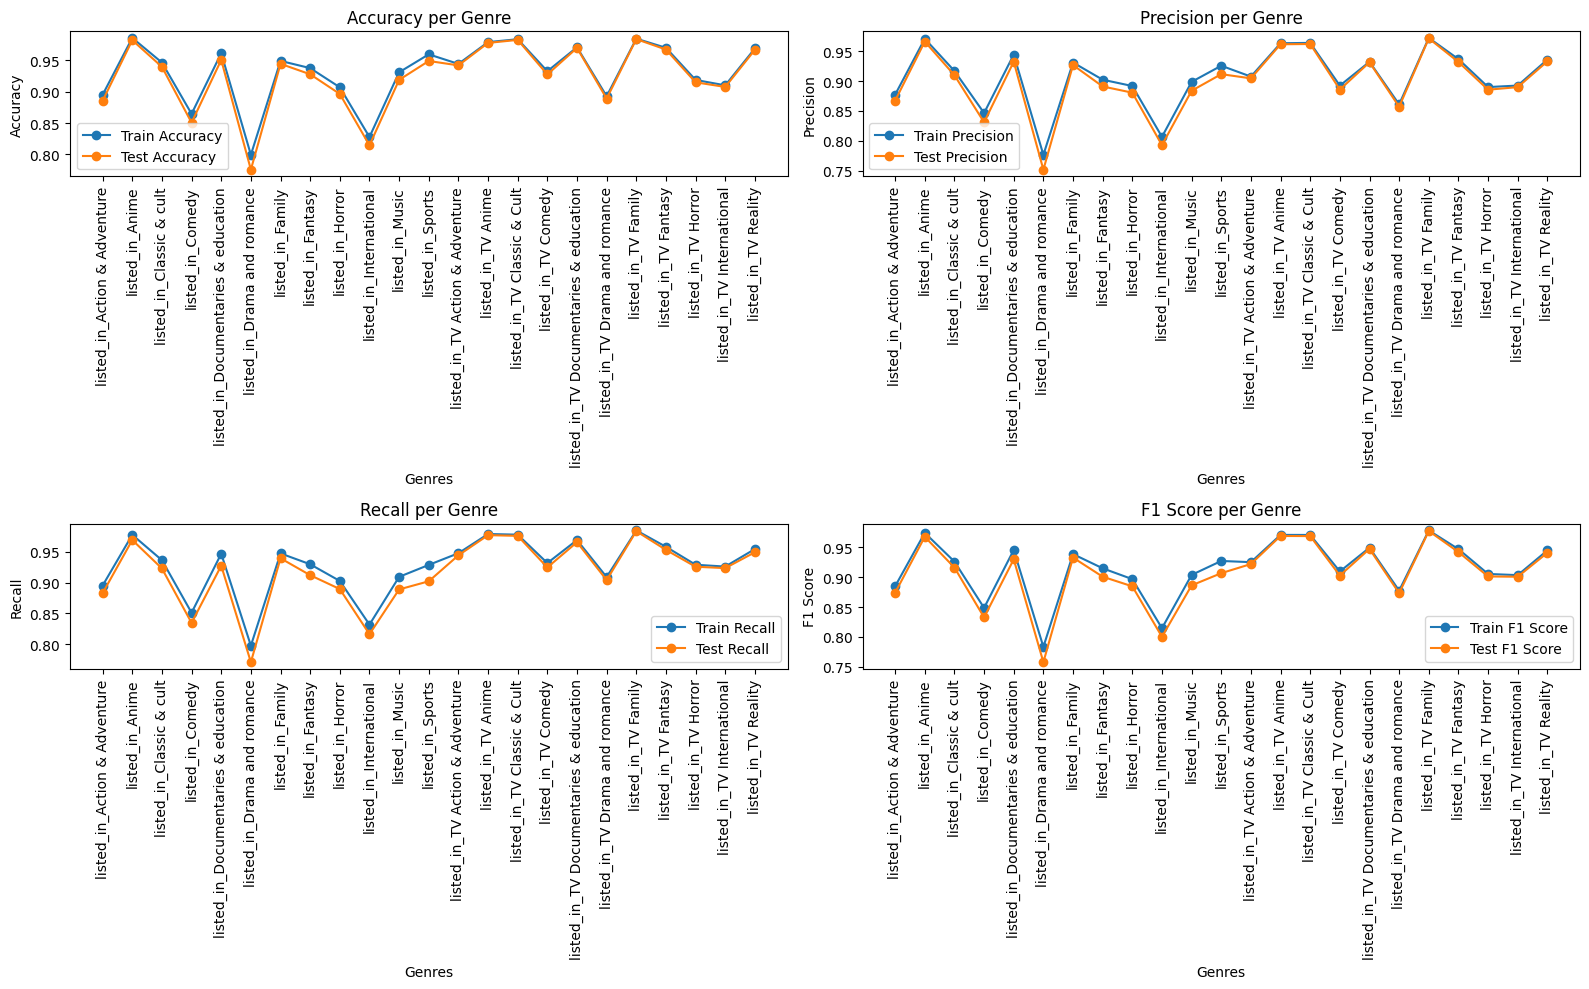

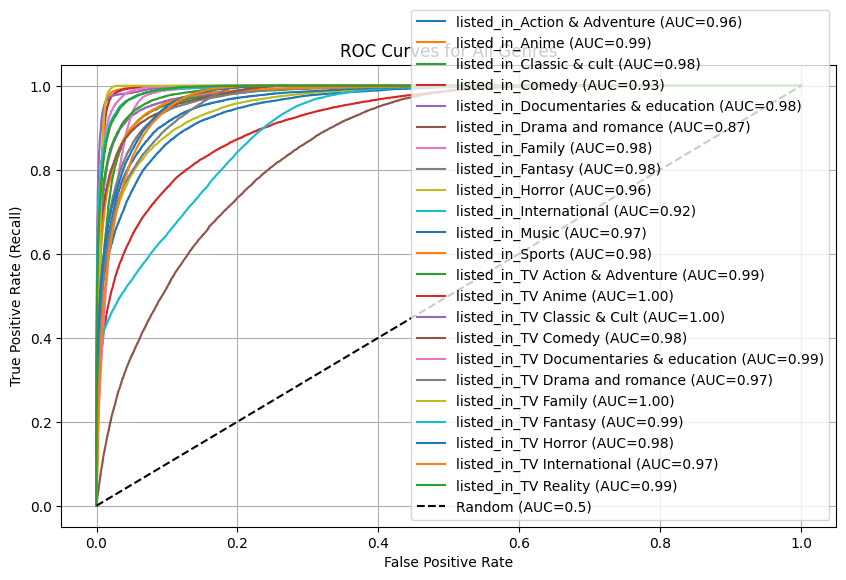

In [ ]:
from sklearn.metrics import roc_curve, auc

best_models = {}
fpr_all = []
tpr_all = []
roc_auc_all = []


correct_positives = {}
false_positives = {}
false_negatives = {}


global_train_accuracies = []
global_test_accuracies = []
global_train_precisions = []
global_test_precisions = []
global_train_recalls = []
global_test_recalls = []
global_train_f1_scores = []
global_test_f1_scores = []


smote_strategies = {
    'listed_in_Action & Adventure': 0.5,
    'listed_in_Anime': 0.2,
    'listed_in_Classic & cult': 0.3,
    'listed_in_Comedy': 0.5,
    'listed_in_Documentaries & education': 0.3,
    'listed_in_Drama and romance': 0.5,
    'listed_in_Family': 0.4,
    'listed_in_Fantasy': 0.3,
    'listed_in_Horror': 0.5,
    'listed_in_International': 0.5,
    'listed_in_Music': 0.3,
    'listed_in_Sports': 0.2,
    'listed_in_TV Action & Adventure': 0.3,
    'listed_in_TV Anime': 0.3,
    'listed_in_TV Classic & Cult': 0.2,
    'listed_in_TV Comedy': 0.3,
    'listed_in_TV Documentaries & education': 0.2,
    'listed_in_TV Drama and romance': 0.4,
    'listed_in_TV Family': 0.3,
    'listed_in_TV Fantasy': 0.2,
    'listed_in_TV Horror': 0.4,
    'listed_in_TV International': 0.5,
    'listed_in_TV Reality': 0.2,
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}  # Per optimització de CategoricalNB


for genre in listed_ins:
    print(f"\nClassificant el gènere: {genre}")
    y = df[genre]  
    selected_columns = list(selected_features.get(genre, X.columns))  
    X_selected = X[selected_columns]

    strategy = smote_strategies.get(genre, 0.3)  
    smote = SMOTE(sampling_strategy=strategy, random_state=42)

    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    grid_search = GridSearchCV(
        estimator=CategoricalNB(),
        param_grid=param_grid,
        scoring='f1_macro',
        cv=skf,
        n_jobs=-1
    )
    grid_search.fit(X_resampled, y_resampled)
    best_model = grid_search.best_estimator_

    best_models[genre] = best_model

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
    )

    best_model.fit(X_train, y_train)


    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_f1 = f1_score(y_train, y_pred_train, average='macro')
    test_f1 = f1_score(y_test, y_pred_test, average='macro')

    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    train_precision = precision_score(y_train, y_pred_train, average='macro')
    test_precision = precision_score(y_test, y_pred_test, average='macro')

    train_recall = recall_score(y_train, y_pred_train, average='macro')
    test_recall = recall_score(y_test, y_pred_test, average='macro')

    global_train_f1_scores.append(train_f1)
    global_test_f1_scores.append(test_f1)
    
    global_train_accuracies.append(train_accuracy)
    global_test_accuracies.append(test_accuracy)

    global_train_precisions.append(train_precision)
    global_test_precisions.append(test_precision)

    global_train_recalls.append(train_recall)
    global_test_recalls.append(test_recall)

    
    print(f"Accuracy (train): {train_accuracy:.2f}, Accuracy (test): {test_accuracy:.2f}")
    print(f"Precision (train): {train_precision:.2f}, Precision (test): {test_precision:.2f}")
    print(f"Recall (train): {train_recall:.2f}, Recall (test): {test_recall:.2f}")
    
    
    correct_positive_indices = (y_test == 1) & (y_pred_test == 1)
    false_positive_indices = (y_test == 0) & (y_pred_test == 1)
    false_negative_indices = (y_test == 1) & (y_pred_test == 0)

    
    correct_positives[genre] = X_test[correct_positive_indices]
    false_positives[genre] = X_test[false_positive_indices]
    false_negatives[genre] = X_test[false_negative_indices]

    print(f"Correctes (1 -> 1): {correct_positive_indices.sum()}")
    print(f"Falsos positius (0 -> 1): {false_positive_indices.sum()}")
    print(f"Falsos negatius (1 -> 0): {false_negative_indices.sum()}")
    
    
    if len(best_model.classes_) > 1:  
        y_proba_test = best_model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_proba_test[:, 1])
        roc_auc = auc(fpr, tpr)
        
        fpr_all.append(fpr)
        tpr_all.append(tpr)
        roc_auc_all.append(roc_auc)



for genre in listed_ins:
    correct_positives[genre].to_csv(f"{genre}_correct_positives.csv", index=False)
    false_positives[genre].to_csv(f"{genre}_false_positives.csv", index=False)
    false_negatives[genre].to_csv(f"{genre}_false_negatives.csv", index=False)



plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(listed_ins, global_train_accuracies, label='Train Accuracy', marker='o')
plt.plot(listed_ins, global_test_accuracies, label='Test Accuracy', marker='o')
plt.title("Accuracy per Genre")
plt.xlabel("Genres")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(rotation=90)


plt.subplot(2, 2, 2)
plt.plot(listed_ins, global_train_precisions, label='Train Precision', marker='o')
plt.plot(listed_ins, global_test_precisions, label='Test Precision', marker='o')
plt.title("Precision per Genre")
plt.xlabel("Genres")
plt.ylabel("Precision")
plt.legend()
plt.xticks(rotation=90)


plt.subplot(2, 2, 3)
plt.plot(listed_ins, global_train_recalls, label='Train Recall', marker='o')
plt.plot(listed_ins, global_test_recalls, label='Test Recall', marker='o')
plt.title("Recall per Genre")
plt.xlabel("Genres")
plt.ylabel("Recall")
plt.legend()
plt.xticks(rotation=90)


plt.subplot(2, 2, 4)
plt.plot(listed_ins, global_train_f1_scores, label='Train F1 Score', marker='o')
plt.plot(listed_ins, global_test_f1_scores, label='Test F1 Score', marker='o')
plt.title("F1 Score per Genre")
plt.xlabel("Genres")
plt.ylabel("F1 Score")
plt.legend()
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))


for i, genre in enumerate(listed_ins):
    plt.plot(fpr_all[i], tpr_all[i], label=f"{genre} (AUC={roc_auc_all[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.5)")

plt.title("ROC Curves for All Genres")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



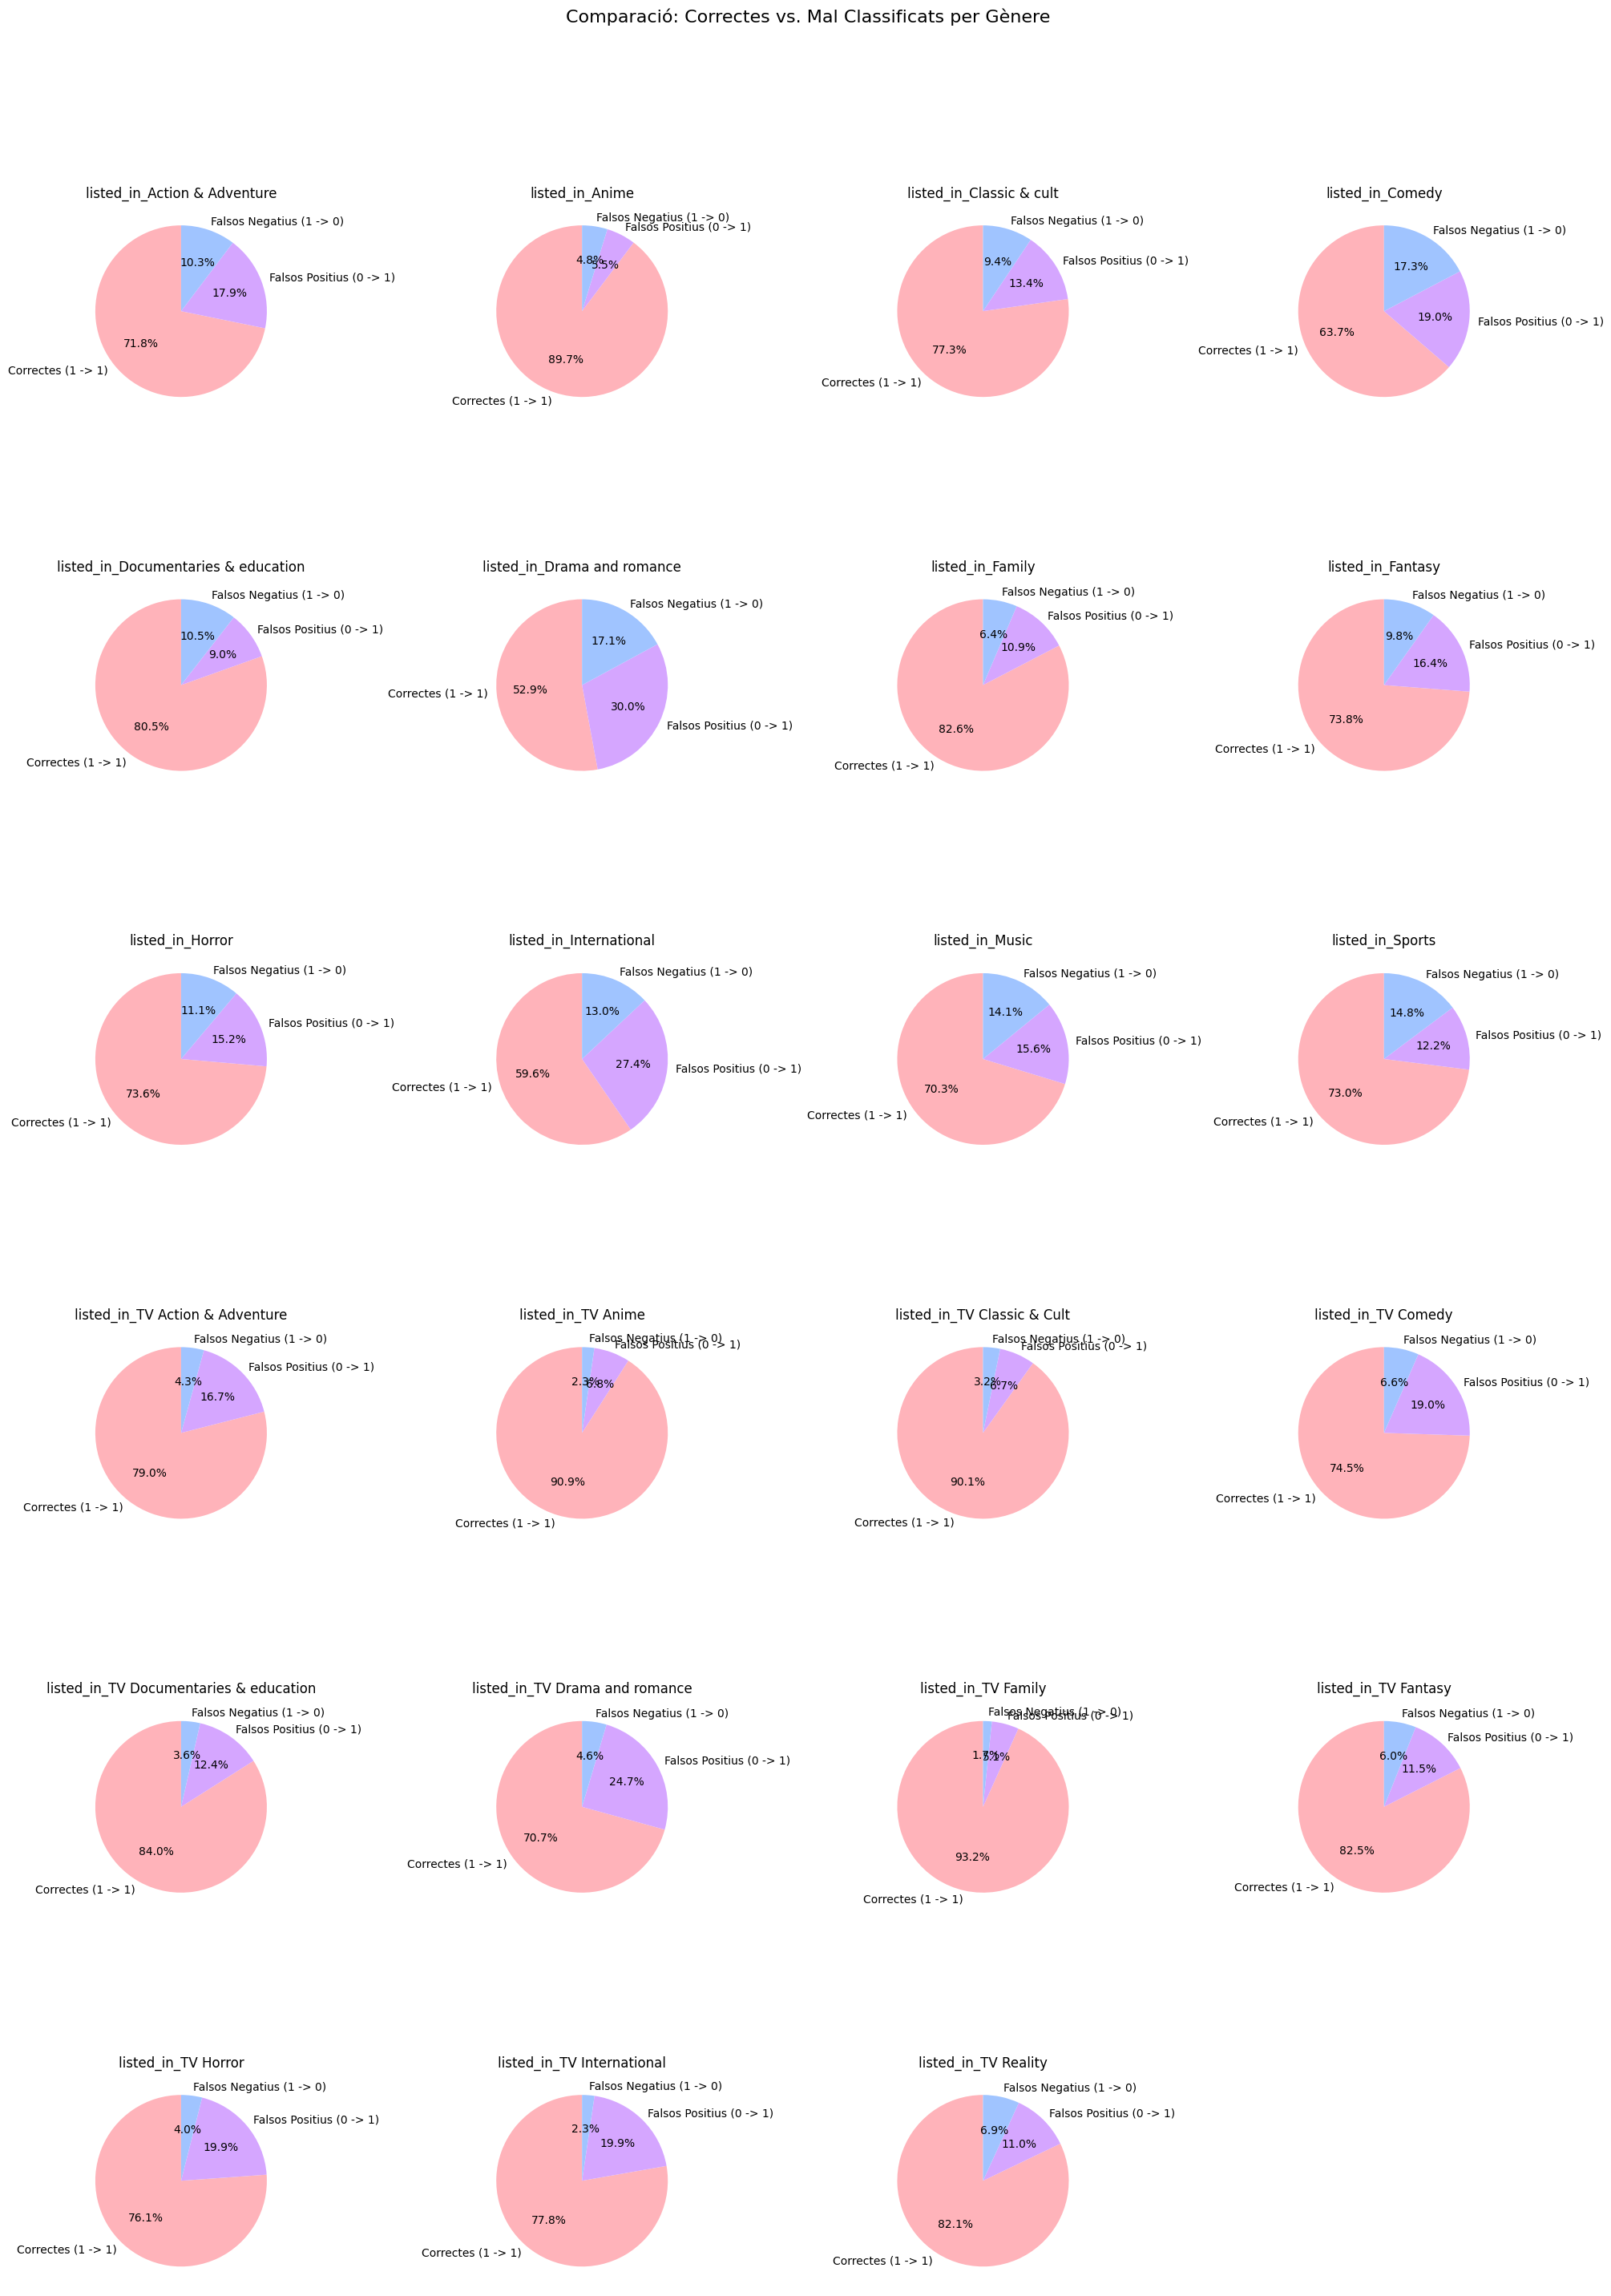

In [ ]:
import matplotlib.pyplot as plt
import math

num_genres = len(listed_ins)
cols = 4  
rows = math.ceil(num_genres / cols)  

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), subplot_kw={'aspect': 'equal'})
axes = axes.flatten()  


colors_pastel = ['#FFB3BA', '#D5A6FF', '#A0C4FF']  

for i, genre in enumerate(listed_ins):
    correct_count = len(correct_positives[genre])
    false_positive_count = len(false_positives[genre])
    false_negative_count = len(false_negatives[genre])

    total_count = correct_count + false_positive_count + false_negative_count


    if total_count > 0:
        labels = ['Correctes (1 -> 1)', 'Falsos Positius (0 -> 1)', 'Falsos Negatius (1 -> 0)']
        sizes = [correct_count, false_positive_count, false_negative_count]
        
        
        axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors_pastel, startangle=90)
        axes[i].set_title(genre, fontsize=12)


for j in range(num_genres, len(axes)):
    fig.delaxes(axes[j])


plt.suptitle("Comparació: Correctes vs. Mal Classificats per Gènere", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

def recommend_movies(movie_title, df, listed_ins, best_models, top_n=5):
   
    if movie_title not in df['title'].values:
        return f"La pel·lícula '{movie_title}' no es troba al dataset."

    movie_row = df[df['title'] == movie_title]
    movie_features = movie_row.iloc[0]

    predicted_genres = []
    for genre, model in best_models.items():
        feature_list = list(selected_features.get(genre, list(X.columns)))
        features = movie_features[feature_list].values.reshape(1, -1)
        prediction = model.predict(features)
        if prediction[0] == 1:
            predicted_genres.append(genre)

    if not predicted_genres:
        return f"No s'ha detectat cap gènere per a la pel·lícula '{movie_title}'."

    print(f"Gèneres detectats per '{movie_title}': {predicted_genres}")

    genre_filter = df[predicted_genres].any(axis=1)
    filtered_df = df[genre_filter]

    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['description'])

    movie_index = filtered_df.index[filtered_df['title'] == movie_title].tolist()[0]

    cosine_sim = cosine_similarity(tfidf_matrix[movie_index], tfidf_matrix).flatten()

    filtered_df = filtered_df.copy()
    filtered_df['cosine_similarity'] = cosine_sim

    filtered_df = filtered_df.sort_values(by='cosine_similarity', ascending=False)

    same_genre_df = filtered_df[filtered_df[predicted_genres].all(axis=1)]

    if len(same_genre_df) < top_n:
        remaining_df = filtered_df[~filtered_df.index.isin(same_genre_df.index)]
        recommendations = pd.concat([same_genre_df, remaining_df]).drop_duplicates(subset=['title']).head(top_n)
    else:
        recommendations = same_genre_df.drop_duplicates(subset=['title']).head(top_n)

    recommendations = recommendations[recommendations['title'] != movie_title]

    if len(recommendations) < top_n:
        other_movies = df[~df['title'].isin(recommendations['title'])].drop_duplicates(subset=['title'])
        extra_recommendations = other_movies.head(top_n - len(recommendations))
        recommendations = pd.concat([recommendations, extra_recommendations])

    recommendations['cosine_similarity'] = (recommendations['cosine_similarity'] * 100).round(2)

   
    recommendations['genres'] = recommendations[predicted_genres].apply(
        lambda row: ', '.join([genre for genre in predicted_genres if row[genre] == 1]), axis=1
    )

    
    return tabulate(recommendations[['title', 'genres', 'cosine_similarity']], headers='keys', tablefmt='grid', showindex=False)


recommended = recommend_movies(
    movie_title="Inception",
    df=df,
    listed_ins=listed_ins,
    best_models=best_models,
    top_n=5  
)

print(recommended)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but CategoricalNB was fit

Gèneres detectats per 'Inception': ['listed_in_Action & Adventure', 'listed_in_Fantasy', 'listed_in_Horror']
+-------------------------+------------------------------+---------------------+
| title                   | genres                       |   cosine_similarity |
+=========================+==============================+=====================+
| The Last Airbender      | listed_in_Fantasy            |              100    |
+-------------------------+------------------------------+---------------------+
| Shootout at Lokhandwala | listed_in_Action & Adventure |               11.3  |
+-------------------------+------------------------------+---------------------+
| Mars Attacks!           | listed_in_Fantasy            |               10.21 |
+-------------------------+------------------------------+---------------------+
| The Blue Elephant 2     | listed_in_Horror             |               10.03 |
+-------------------------+------------------------------+---------------------+


# **7. RECCOMENDATION**

Content-based

Historial de visualització: Netflix analitza quins títols has vist (pel·lícules, sèries, documentals), el temps que hi has dedicat i si els has acabat o no. Si acabes una sèrie, es considera que t’ha agradat més que si només en veus un episodi o l'abandones a mitges.

Categories de gènere i temàtica: Cada títol a Netflix està etiquetat amb múltiples categories (per exemple, "comèdia romàntica", "drama policíac", "ciència ficció"). El sistema detecta els gèneres i subgèneres que més consumeixes per recomanar-te contingut similar.

Valoracions i reaccions dels usuaris: Netflix també considera si fas clic a “M'agrada” o “No m'agrada” en certs títols. Aquestes interaccions ajuden a perfilar millor el teu gust.

Moment i context de visualització: L'algoritme pot captar patrons en els moments en què consumes determinats tipus de contingut. Per exemple, potser prefereixes veure sèries llargues durant el cap de setmana i pel·lícules d'acció a la nit.

Popularitat a la teva regió: Netflix té en compte les tendències locals. Si hi ha títols que estan de moda en el teu país o regió, tenen més probabilitat d'aparèixer en les recomanacions, fins i tot si no segueixen les teves preferències històriques.

Anàlisi de similitud d'usuaris (collaborative filtering): Mitjançant tècniques de “filtratge col·laboratiu”, Netflix compara el teu perfil amb altres usuaris amb gustos similars i recomana contingut que altres usuaris amb preferències semblants han vist i valorat positivament.

Contingut similar: Netflix també pot fer servir un model de "content-based filtering", que recomana continguts similars als que ja has vist. Això es basa en característiques de les pel·lícules i sèries, com actors, directors o gèneres comuns.

type: Aquest atribut especifica si el contingut és una pel·lícula o una sèrie. Pot ajudar a filtrar recomanacions segons el tipus que l'usuari prefereixi, ja que algunes persones poden tenir una preferència clara per un tipus de format sobre l'altre.

listed_in: Aquest atribut representa els gèneres o categories (com comèdia, drama, acció, documentals, etc.) en què s’emmarca el contingut. És probablement dels més importants, ja que els usuaris tenen tendència a preferir certs gèneres i subgèneres.

cast i director: Aquests atributs són útils perquè moltes persones tenen preferències per certs actors o directors. Si l'usuari ha vist diversos continguts amb el mateix actor o director, es pot deduir que és una característica atractiva per a ell.

country: El país de producció pot influir en les preferències, ja que pot indicar una preferència per continguts d'una cultura o regió específica. Això és especialment rellevant en les plataformes globals com Netflix, que ofereixen continguts d'arreu del món.

release_year: L'any d'estrena pot ajudar a recomanar contingut segons preferències de dècades o períodes concrets. Si algú prefereix contingut modern o, per contra, pel·lícules i sèries clàssiques, aquest atribut és rellevant.

duration: Tot i que no sempre és clau, la durada pot ser útil per ajustar les recomanacions en funció de l'estil de visualització de l'usuari. Per exemple, si algú sol veure continguts més curts, es poden prioritzar les pel·lícules o sèries amb episodis més breus.

rating: La classificació per edat pot ser útil si l'algoritme detecta preferències per certs nivells de maduresa del contingut (com "PG-13", "R", etc.). També pot ser útil si es volen fer recomanacions adequades per a una audiència de certa edat.

description: Tot i que no és un atribut directe per a les recomanacions, es podria analitzar amb processament de llenguatge natural per extreure paraules clau que permetin recomanar contingut amb temàtiques similars.

Atributs menys rellevants:
show_id: És només un identificador únic per a cada registre i no aporta informació sobre les preferències de l'usuari.
title: En general, el títol per si sol no aporta informació rellevant per a la recomanació, tot i que podria utilitzar-se com a punt de partida per buscar patrons en sèries o franquícies similars.
En conjunt, podries crear un sistema de recomanació combinant factors com els gèneres (listed_in), el tipus de contingut (type), els actors i directors (cast, director), el país de producció (country), i l'any d'estrena (release_year) per fer una proposta ajustada als interessos de l'usuari.

Un cop classificat l'atribut *listed_in*, plantegem els possibles recomanadors que podem implementar: 
* **Content-Based Filtering**: Recomana pel·lícules similars a les que l'usuari ja ha vist basant-se en atributs (gèneres, actors, director, descripció...).
* **Collaborative Filtering**: Recomana pel·lícules basant-se en preferències similars d'altres usuaris que han vist pel·lícules semblants.

Basant-nos en el nostre dataset considerem adient la primera opció. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
import pandas as pd

def recommend_movies(movie_title, df, top_n=5):

    if movie_title not in df['title'].values:
        return f"La pel·lícula '{movie_title}' no es troba al dataset."

    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['description'])

    movie_index = df.index[df['title'] == movie_title].tolist()[0]

    cosine_sim = cosine_similarity(tfidf_matrix[movie_index], tfidf_matrix).flatten()

    df = df.copy()
    df['cosine_similarity'] = cosine_sim

    input_movie_genres = df.loc[movie_index, 'listed_in'].split(", ")
    print(f"Gèneres detectats per '{movie_title}': {input_movie_genres}")

    recommendations = df[df['title'] != movie_title].sort_values(by='cosine_similarity', ascending=False)

    recommendations['shared_genres'] = recommendations['listed_in'].apply(
        lambda genres: len(set(input_movie_genres) & set(genres.split(", ")))
    )
    same_genre_df = recommendations[recommendations['shared_genres'] == len(input_movie_genres)]

    if len(same_genre_df) < top_n:
        partial_genre_df = recommendations[(recommendations['shared_genres'] > 0) & 
                                            (~recommendations.index.isin(same_genre_df.index))]
        recommendations = pd.concat([same_genre_df, partial_genre_df]).drop_duplicates(subset='title').head(top_n)
    else:
        recommendations = same_genre_df.drop_duplicates(subset='title').head(top_n)

    recommendations['cosine_similarity'] = (recommendations['cosine_similarity'] * 100).round(2)

    recommendations['genres'] = recommendations['listed_in'].apply(
        lambda genres: ", ".join([f"listed_in_{genre}" for genre in genres.split(", ")])
    )

    recommendations = recommendations.head(top_n)

    return tabulate(recommendations[['title', 'genres', 'cosine_similarity']], 
                    headers='keys', tablefmt='grid', showindex=False)


recommended = recommend_movies(
    movie_title="Inception",
    df=df,
    top_n=5 
)

print(recommended)


Gèneres detectats per 'Inception': ['Action & Adventure']
+----------------------------+------------------------------+---------------------+
| title                      | genres                       |   cosine_similarity |
+============================+==============================+=====================+
| Quigley Down Under         | listed_in_Action & Adventure |               11.75 |
+----------------------------+------------------------------+---------------------+
| Drive                      | listed_in_Action & Adventure |               10.45 |
+----------------------------+------------------------------+---------------------+
| Black                      | listed_in_Action & Adventure |                9.26 |
+----------------------------+------------------------------+---------------------+
| Team America: World Police | listed_in_Action & Adventure |                9.12 |
+----------------------------+------------------------------+---------------------+
| Beauty and the B